# Analysis code for _Intensional Gaps_

[Aaron Steven White](http://aaronstevenwhite.io)<br/>
*University of Rochester*<br/>
aaron.white@rochester.edu<br/>
*Last updated*: 8 May 2021

This notebook contains all of the analyses from:

> Kane, Benjamin, William Gantt, and Aaron Steven White. 2021. [Intensional gaps: Relating doxasticity, bouleticity, veridicality, factivity, and neg-raising](https://ling.auf.net/lingbuzz/005930/current.pdf). Accepted to _Semantics and Linguistic Theory_ 31.

If you use any of the code found in this directory, please cite that paper as well as [this repository](https://github.com/MegaAttitude/intensional-gaps.git).

## Notebook Contents

Code relevant to each of the following sections can be jumped to using the links below.

- [Section 3 (Validating a templatic approach)](#Validating-a-templatic-approach)
- [Section 4 (Lexicon-scale data collection)](#Lexicon-scale-data-collection)
- [Section 5 (Discovering inference patterns)](#Discovering-inference-patterns)

These links will not work when viewing this notebook on github.

## Environment Setup

It is strongly recommended that you run this notebook using the docker image it is shipped with. See the README shipped with this notebook for details. The relevant Dockerfile is duplicated below.

```
FROM jupyter/datascience-notebook:r-3.6.3

RUN pip install pyro-ppl==1.5.1 &&\
    R -e "install.packages(c('tidyverse', 'lme4', 'glmmTMB', 'ggrepel'), repos = 'https://cloud.r-project.org')"
```

To run the jupyter notebook server, use:

```bash
docker run -it --rm --user $(id -u):$(id -g) --group-add users -v "$(pwd)":/home/jovyan -p 8888:8888 --name intensional-gaps intensional-gaps
```

Failure to use this docker image could result in minor differences in statistics from the published paper or inability to run the code at all due to API changes.

In [1]:
# base libraries
import os
import re
import json

from typing import List, Optional
from warnings import warn
from dataclasses import dataclass
from collections import defaultdict

# numerical computing libraries
import numpy as np
import scipy.stats
import pandas as pd
import torch

from numpy.linalg import inv
from numpy import logaddexp
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import spearmanr

# mixture model
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide.initialization import init_to_uniform
from pyro.infer import MCMC, NUTS

# regression, cross-validation, and PCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

# plotting libraries
import seaborn as sns
import rpy2
%load_ext rpy2.ipython

/opt/conda/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


All the data needed for the analyses in this notebook are downloaded at run time, so an internet connection is also required.

In [2]:
!mkdir -p data
!mkdir -p plots

In cases where values on $[0, 1]$ must be clipped to $(0, 1)$—e.g. for models that use the Beta distribution—we use the following values.

In [3]:
ZERO = 1e-5
ONE = 1 - ZERO

## Validating a templatic approach

Section 3 of the paper presents a study validating the use of our proposed templatic bleaching method. This study has two components: a norming study and a validation study.

### Norming study

The norming study aims to measure the prior probability that a particular generic belief or desire holds among entities under a description.

In [4]:
project_href = "http://megaattitude.io/projects/mega-intensionality/"
norming_href = project_href + "mega-intensionality-norming-v1/mega-intensionality-norming-v1.tsv"

norming = pd.read_csv(norming_href, sep='\t')

norming

,listid,participant,verb,subject,consequent,valence,question,response
0,0,96,notify,mechanic,want,negative,What proportion of mechanics generally want ca...,0.00
1,0,33,notify,mechanic,want,negative,What proportion of mechanics generally want ca...,0.00
2,0,2,notify,mechanic,want,negative,What proportion of mechanics generally want ca...,0.17
3,0,59,notify,mechanic,want,negative,What proportion of mechanics generally want ca...,0.10
4,0,29,notify,mechanic,want,negative,What proportion of mechanics generally want ca...,0.06
...,...,...,...,...,...,...,...,...
4795,1,92,boast,fire fighter,believe,positive,What proportion of fire fighters generally bel...,1.00
4796,1,97,boast,fire fighter,believe,positive,What proportion of fire fighters generally bel...,0.81
4797,1,10,boast,fire fighter,believe,positive,What proportion of fire fighters generally bel...,0.88
4798,1,48,boast,fire fighter,believe,positive,What proportion of fire fighters generally bel...,0.23


The items are designed to induce bimodality in responses to the desire items, which we observe.

In [5]:
def bootstrap_mean(x, iters=999):
    bootstrapped_means = [np.mean(np.random.choice(x, size=x.shape[0])) for _ in range(iters)]
    return np.quantile(bootstrapped_means, [0.025, 0.5, 0.975])

id_vars = ['verb', 'subject', 'valence', 'consequent']

norming_mean = norming.groupby(id_vars).response.apply(bootstrap_mean).reset_index()

norming_mean['cilo'] = norming_mean.response.map(lambda x: x[0])
norming_mean['med'] = norming_mean.response.map(lambda x: x[1])
norming_mean['cihi'] = norming_mean.response.map(lambda x: x[2])

norming_mean = norming_mean.drop(columns='response')

norming_mean

,verb,subject,valence,consequent,cilo,med,cihi
0,apologize,child,positive,believe,0.78078,0.8324,0.87444
1,apologize,child,positive,want,0.95440,0.9788,0.99440
2,apologize,clerk,negative,believe,0.17640,0.2500,0.34082
3,apologize,clerk,negative,want,0.04000,0.1020,0.18800
4,apologize,teacher,positive,believe,0.72794,0.7876,0.84920
...,...,...,...,...,...,...,...
187,worry,guitarist,positive,want,0.92078,0.9608,0.98522
188,worry,journalist,negative,believe,0.17998,0.2312,0.28720
189,worry,journalist,negative,want,0.00918,0.0232,0.04080
190,worry,waiter,negative,believe,0.14558,0.1884,0.24242


More generally, we succeed in inducing high variability in the judgments for both _belief_ and _want_ items, which can be seen in Figure 1 of the paper (plotted below).

R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

R[write to console]: ✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



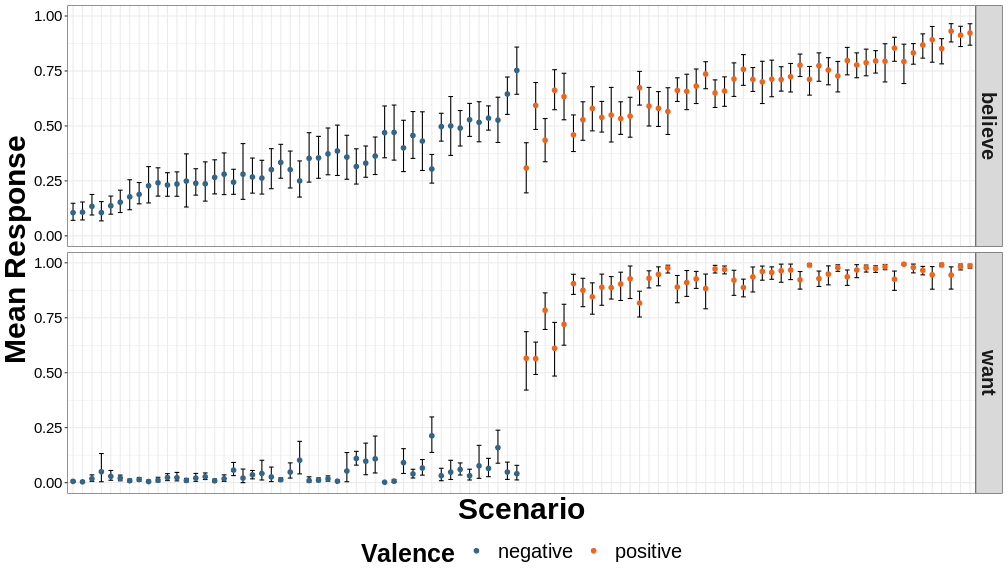

In [6]:
%%R -i norming_mean -w 14 -h 8 -u in

library(tidyverse)

theme_set(theme_bw())

norming_mean$item = interaction(norming_mean$subject, 
                                norming_mean$verb, 
                                norming_mean$valence)

g <- ggplot(norming_mean, aes(x=fct_reorder(item, med), y=med, ymax=cihi, ymin=cilo, color=valence)) + 
     geom_errorbar(color="black", width=0.5) + 
     geom_point(size=2) +
     facet_grid(consequent~.) +
     scale_color_manual(name='Valence', values=c("#33658a", "#f26419")) +
     xlab('Scenario') +
     ylab('Mean Response') +
     theme(axis.ticks.x=element_blank(),
           axis.text.x=element_blank(),
           strip.text=element_text(face="bold", size=20),
           axis.title=element_text(face="bold", size=30),
           axis.text.y=element_text(size=15, color="black"),
           legend.position="bottom",
           legend.title=element_text(face="bold", size=25),
           legend.text=element_text(size=20))

ggsave('plots/norming_means.png', width=14, height=8)
ggsave('plots/norming_means.pdf', width=14, height=8)

g

To obtain a single score for each item that adjusts for annotator differences in scale use, we fit a mixed effects beta regression to the responses, then use this model to predict a judgment for each item, setting the participant random effects to 0 and the predicate random effects to their best linear unbiased predictors. These predictions can be thought of as those that the "average" participant would give. 

Prior to fitting the model, we clip the responses because beta regression cannot handle 0s and 1s. (An alternative is to use 0-1 inflated beta regression, but we do not believe the extra complexity is warranted for current purposes.)

In [7]:
norming['response_clipped'] = norming.response.clip(ZERO, ONE)

In [8]:
%%R -i norming

library(glmmTMB)

set.seed(403928)

norming$item = interaction(norming$verb, norming$subject)

norming$consequent = relevel(as.factor(norming$consequent), 'want')
norming$valence = relevel(as.factor(norming$valence), 'positive')

contrasts(norming$valence) = contr.sum(levels(norming$valence))

m.norming = glmmTMB(response_clipped ~ consequent*valence + (1+consequent|item) + (1+consequent*valence|participant),
                    data=norming, family=list(family="beta",link="logit"))

We set the participant random effects to 0 (by changing all of the participants identifiers to one that does not exist in the data. The best linear unbiased predictors for the predicate random effects are used by `predict` by default.

In [9]:
%%R -o norming_normalized

norming$participant = max(norming$participant) + 1

norming$response_normalized = predict(m.norming, norming, allow.new.levels=TRUE)

norming_normalized = norming %>% 
                     group_by(consequent, valence, verb, subject) %>%
                     summarise(norm=mean(response_normalized))  

norming_normalized

R[write to console]: `summarise()` has grouped output by 'consequent', 'valence', 'verb'. You can override using the `.groups` argument.



# A tibble: 192 x 5
# Groups:   consequent, valence, verb [96]
   consequent valence  verb         subject       norm
   <fct>      <fct>    <chr>        <chr>        <dbl>
 1 want       positive apologize    child        2.69 
 2 want       positive apologize    teacher      2.53 
 3 want       positive boast        dancer       2.43 
 4 want       positive boast        fire fighter 2.72 
 5 want       positive complain     dishwasher   0.388
 6 want       positive complain     model        2.15 
 7 want       positive congratulate conductor    2.60 
 8 want       positive congratulate moderator    1.65 
 9 want       positive convince     concierge    2.03 
10 want       positive convince     therapist    2.35 
# … with 182 more rows


In [10]:
norming_normalized

,consequent,valence,verb,subject,norm
1,want,positive,apologize,child,2.685216
2,want,positive,apologize,teacher,2.528396
3,want,positive,boast,dancer,2.431844
4,want,positive,boast,fire fighter,2.723670
5,want,positive,complain,dishwasher,0.388023
...,...,...,...,...,...
188,believe,negative,think,doctor,0.174639
189,believe,negative,wish,politician,-0.857435
190,believe,negative,wish,salesman,-0.041312
191,believe,negative,worry,journalist,-0.946597


### Validation Study

The aim of the validation study is to ensure that gathering data using templatic items yields the same information about the inferential properties of the lexical items in the antecedents as an approach that uses contentful items and adjusts for world knowledge.

The responses to the templatic and contentful items are bundled together.

In [11]:
validation_href = project_href + 'mega-intensionality-validation-v1/mega-intensionality-validation-v1.tsv'

validation = pd.read_csv(validation_href, sep='\t')

validation['response_clipped'] = validation.response.clip(ZERO, ONE)

validation

,listid,participant,verb,subject,target,consequent,polarity,tense,valence,question,transitivity,response,response_clipped
0,4,210,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90000
1,4,319,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.88,0.88000
2,4,7,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.97,0.97000
3,4,259,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.81,0.81000
4,4,308,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15355,14,203,love,A,subject,believe,negative,future,neutral,A didn't love that C would happen.How likely i...,intransitive,0.43,0.43000
15356,14,3,love,A,subject,believe,negative,future,neutral,A didn't love that C would happen.How likely i...,intransitive,1.00,0.99999
15357,14,3,love,A,subject,want,positive,future,neutral,A loved that C would happen.How likely is it t...,intransitive,1.00,0.99999
15358,14,179,love,A,subject,want,positive,future,neutral,A loved that C would happen.How likely is it t...,intransitive,1.00,0.99999


The templatic items can be identified by a `"neutral"` label for `valence`.

In [12]:
validation_templatic = validation.query('valence == "neutral"')

validation_templatic

,listid,participant,verb,subject,target,consequent,polarity,tense,valence,question,transitivity,response,response_clipped
7680,10,152,persuade,A,object,believe,negative,future,neutral,A didn't persuade B that C would happen.How li...,transitive,0.19,0.19000
7681,10,152,persuade,A,object,want,positive,future,neutral,A persuaded B that C would happen.How likely i...,transitive,0.42,0.42000
7682,10,262,persuade,A,object,believe,negative,future,neutral,A didn't persuade B that C would happen.How li...,transitive,0.26,0.26000
7683,10,262,persuade,A,object,want,positive,future,neutral,A persuaded B that C would happen.How likely i...,transitive,0.34,0.34000
7684,10,212,persuade,A,object,want,positive,future,neutral,A persuaded B that C would happen.How likely i...,transitive,0.50,0.50000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15355,14,203,love,A,subject,believe,negative,future,neutral,A didn't love that C would happen.How likely i...,intransitive,0.43,0.43000
15356,14,3,love,A,subject,believe,negative,future,neutral,A didn't love that C would happen.How likely i...,intransitive,1.00,0.99999
15357,14,3,love,A,subject,want,positive,future,neutral,A loved that C would happen.How likely is it t...,intransitive,1.00,0.99999
15358,14,179,love,A,subject,want,positive,future,neutral,A loved that C would happen.How likely is it t...,intransitive,1.00,0.99999


The contentful items can be identified by a non-`"neutral"` (`"positive"` or `"negative"`) label for `valence`.We merge these contentful judgments with the normalized norming scores in preparation for asking how well normalized templatic scores and normalized norming scores together predict the contentful judgments. 

In [13]:
validation_contentful = validation.query('valence != "neutral"')
validation_contentful = pd.merge(validation_contentful, norming_normalized)

validation_contentful

,listid,participant,verb,subject,target,consequent,polarity,tense,valence,question,transitivity,response,response_clipped,norm
0,4,210,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90000,2.447568
1,4,319,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.88,0.88000,2.447568
2,4,7,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.97,0.97000,2.447568
3,4,259,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.81,0.81000,2.447568
4,4,308,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90000,2.447568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,16,36,tell,liquor store owner,subject,want,positive,past,positive,The liquor store owner told the customer that ...,transitive,1.00,0.99999,2.462087
7676,16,85,tell,liquor store owner,subject,want,positive,past,positive,The liquor store owner told the customer that ...,transitive,0.93,0.93000,2.462087
7677,16,141,tell,liquor store owner,subject,want,positive,past,positive,The liquor store owner told the customer that ...,transitive,0.86,0.86000,2.462087
7678,16,217,tell,liquor store owner,subject,want,positive,past,positive,The liquor store owner told the customer that ...,transitive,1.00,0.99999,2.462087


The distribution of responses for both templatic and contentful items are show in Figure 2 of the paper (plotted below).

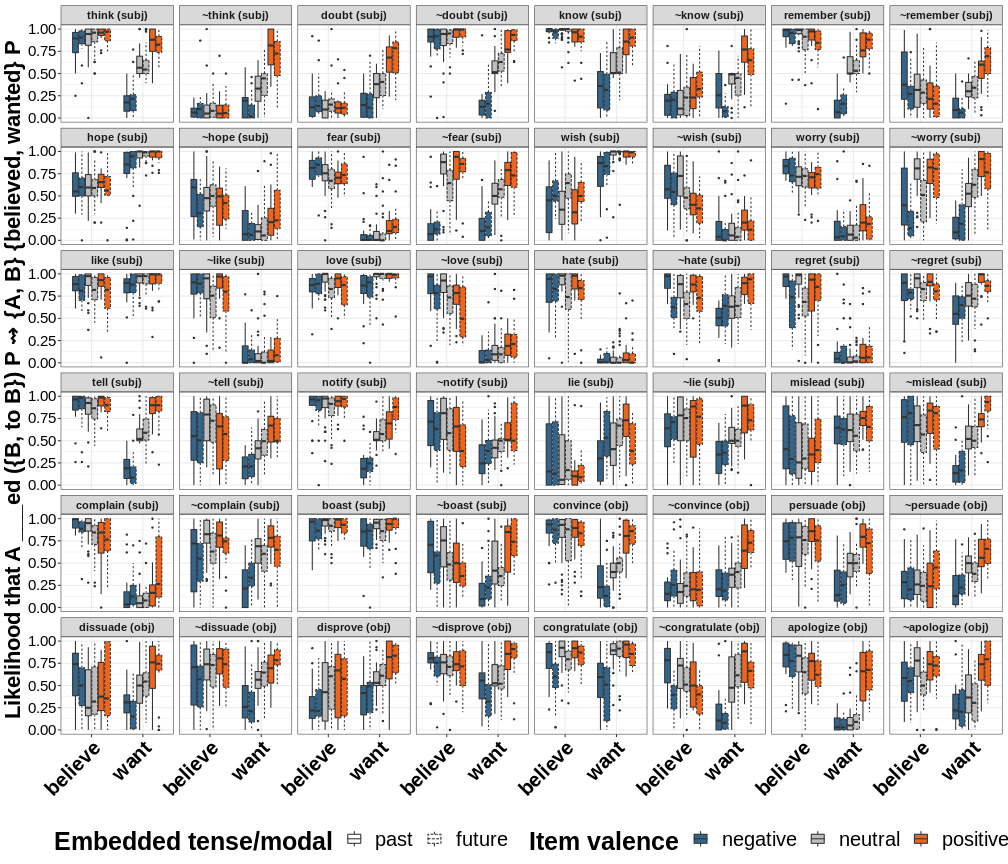

In [14]:
%%R -i validation -w 14 -h 12 -u in

library(tidyverse)

theme_set(theme_bw())

validation$target = ifelse(validation$target == 'subject', 'subj', 'obj')

validation$polarity_verb_target = paste0(ifelse(validation$polarity == 'negative', '~', ''), 
                                                 validation$verb, ' (', validation$target, ')')

ord = c("think (subj)" , "~think (subj)",
        "doubt (subj)", "~doubt (subj)",
        "know (subj)", "~know (subj)" ,       
        "remember (subj)", "~remember (subj)", 
        "hope (subj)", "~hope (subj)",
        "fear (subj)", "~fear (subj)",
        "wish (subj)", "~wish (subj)",
        "worry (subj)", "~worry (subj)",
        "like (subj)", "~like (subj)",
        "love (subj)", "~love (subj)",
        "hate (subj)", "~hate (subj)",
        "regret (subj)", "~regret (subj)",
        "tell (subj)", "~tell (subj)",
        "notify (subj)", "~notify (subj)",
        "lie (subj)", "~lie (subj)",
        "mislead (subj)", "~mislead (subj)",
        "complain (subj)", "~complain (subj)",
        "boast (subj)", "~boast (subj)",
        "convince (obj)", "~convince (obj)",
        "persuade (obj)", "~persuade (obj)",
        "dissuade (obj)", "~dissuade (obj)",
        "disprove (obj)", "~disprove (obj)",
        "congratulate (obj)", "~congratulate (obj)", 
        "apologize (obj)", "~apologize (obj)" )

validation$polarity_verb_target = ordered(validation$polarity_verb_target, 
                                                  levels=ord)

validation$tense = ordered(validation$tense, levels=c('past', 'future'))

g <- ggplot(validation, aes(x=consequent, y=response, fill=valence, linetype=tense)) + 
geom_boxplot(outlier.size=0.5) +
xlab('') +
ylab(paste0('Likelihood that A ___ed ({B, to B}) P ', sprintf('\u21DD'),' {A, B} {believed, wanted} P')) +
scale_fill_manual(name='Item valence', values=c("#33658a", "grey", "#f26419")) +
scale_linetype(name='Embedded tense/modal') +
facet_wrap(~polarity_verb_target, nrow=6) +
theme(strip.text=element_text(face="bold", size=11),
     axis.title.y=element_text(face="bold", size=22),
     axis.text.x=element_text(face="bold", size=20, angle=45, hjust=1, color="black"),
     axis.text.y=element_text(size=15, color="black"),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/validation_distributions.png', width=14, height=12)
ggsave('plots/validation_distributions.pdf', width=14, height=12)

g

To construct normalized scores for the templatic items, we fit a beta mixed effects model.

In [15]:
%%R -i validation_templatic

set.seed(403928)

validation_templatic$consequent = relevel(as.factor(validation_templatic$consequent), 'want')
validation_templatic$polarity = relevel(as.factor(validation_templatic$polarity), 'positive')
validation_templatic$tense = relevel(as.factor(validation_templatic$tense), 'future')

validation_templatic$target = as.factor(paste(validation_templatic$transitivity,
                                              validation_templatic$target, sep='-'))

contrasts(validation_templatic$polarity) = contr.sum(levels(validation_templatic$polarity))
contrasts(validation_templatic$tense) = contr.sum(levels(validation_templatic$tense))

m = glmmTMB(response_clipped ~ consequent*polarity*tense*target + (1+consequent*polarity*tense|verb) + (1+consequent*polarity*tense*target|participant),
            data=validation_templatic, family=list(family="beta",link="logit"))

Then, as for the norming data, we set the participant random effects to 0 (by changing all of the participants identifiers to one that does not exist in the data. The best linear unbiased predictors for the predicate random effects are used by `predict` by default.

In [16]:
%%R -o validation_templatic_normalized

validation_templatic$participant <- max(validation_templatic$participant) + 1

validation_templatic$response_normalized <- predict(m, validation_templatic, allow.new.levels=TRUE)

validation_templatic_normalized <- validation_templatic %>% 
                                   group_by(consequent, polarity, tense, verb) %>%
                                   summarise(neutral=mean(response_normalized))  

validation_templatic_normalized

R[write to console]: `summarise()` has grouped output by 'consequent', 'polarity', 'tense'. You can override using the `.groups` argument.



# A tibble: 192 x 5
# Groups:   consequent, polarity, tense [8]
   consequent polarity tense  verb         neutral
   <fct>      <fct>    <fct>  <chr>          <dbl>
 1 want       positive future apologize    -1.83  
 2 want       positive future boast         1.91  
 3 want       positive future complain     -2.09  
 4 want       positive future congratulate  1.93  
 5 want       positive future convince      0.0619
 6 want       positive future disprove      0.438 
 7 want       positive future dissuade      0.222 
 8 want       positive future doubt        -0.385 
 9 want       positive future fear         -2.45  
10 want       positive future hate         -2.75  
# … with 182 more rows


In [17]:
validation_templatic_normalized

,consequent,polarity,tense,verb,neutral
1,want,positive,future,apologize,-1.829770
2,want,positive,future,boast,1.907626
3,want,positive,future,complain,-2.087370
4,want,positive,future,congratulate,1.930515
5,want,positive,future,convince,0.061861
...,...,...,...,...,...
188,believe,negative,past,remember,-0.655803
189,believe,negative,past,tell,1.414275
190,believe,negative,past,think,-2.097180
191,believe,negative,past,wish,0.792917


We merge these scores with the contenful data.

In [18]:
validation_contentful_templatic = pd.merge(validation_contentful, validation_templatic_normalized)

validation_contentful_templatic

,listid,participant,verb,subject,target,consequent,polarity,tense,valence,question,transitivity,response,response_clipped,norm,neutral
0,4,210,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90,2.447568,0.685068
1,4,319,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.88,0.88,2.447568,0.685068
2,4,7,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.97,0.97,2.447568,0.685068
3,4,259,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.81,0.81,2.447568,0.685068
4,4,308,know,executive,subject,want,positive,future,positive,The executive knew that his deal would go thro...,intransitive,0.90,0.90,2.447568,0.685068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7675,19,51,wish,politician,subject,believe,negative,future,negative,The politician didn't wish that the smear camp...,intransitive,0.55,0.55,-0.857435,-0.292768
7676,19,10,wish,politician,subject,believe,negative,future,negative,The politician didn't wish that the smear camp...,intransitive,0.83,0.83,-0.857435,-0.292768
7677,19,13,wish,politician,subject,believe,negative,future,negative,The politician didn't wish that the smear camp...,intransitive,0.14,0.14,-0.857435,-0.292768
7678,19,37,wish,politician,subject,believe,negative,future,negative,The politician didn't wish that the smear camp...,intransitive,0.54,0.54,-0.857435,-0.292768


To assess how well responses to templatic items capture the same information about the inferential properties of the lexical items as an approach that uses contentful items and adjusts for world knowledge, we assess how well the judgments for contentful items can be predicted given just the normalized scores from the norming experiment and the judgments for the templatic items. 

In [19]:
%%R -i validation_contentful_templatic -o cv_corrs

set.seed(403928)

verb.order = unique(validation_contentful_templatic$verb)

mod.list = c()
verbs = c()
corrs = c()

for (v in verb.order) { 
    train = filter(validation_contentful_templatic, verb !=v)
    test = filter(validation_contentful_templatic, verb == v)
    
    m.norm.by.neutral <- glmmTMB(response_clipped ~ norm*neutral + (1+norm*neutral|verb) + (1+norm*neutral|participant),
                                   data=train, 
                                   family=list(family="beta",link="logit"))
    
    predicted = predict(m.norm.by.neutral, test, allow.new.levels=TRUE)
    spearman = cor(test$response_clipped, predicted, method="spearman")
    
    verbs = c(verbs, v)
    corrs = c(corrs, spearman)
    
    mod.list = c(mod.list, list(mod=m.norm.by.neutral, excluded=v, predicted=predicted))
}

cv_corrs = data.frame(verbs=verbs, corrs=corrs)

cv_corrs

          verbs     corrs
1          know 0.8624611
2      convince 0.7510092
3         boast 0.6949017
4  congratulate 0.6373447
5        notify 0.6936441
6      disprove 0.6084943
7          fear 0.6876655
8         doubt 0.8691683
9      complain 0.6438113
10         like 0.8057272
11         hope 0.7263578
12          lie 0.4986325
13       regret 0.7589643
14     remember 0.8223310
15        worry 0.6769464
16         tell 0.6992485
17     persuade 0.6701830
18    apologize 0.6109846
19        think 0.8685985
20         hate 0.8136686
21     dissuade 0.5034756
22      mislead 0.4421282
23         love 0.7951178
24         wish 0.7111852


The result is an average rank correlation of 0.70.

In [20]:
cv_corrs_stats = np.round(np.quantile([np.mean(np.random.choice(cv_corrs.corrs.values,
                                                                cv_corrs.corrs.values.shape[0])) 
                                       for _ in range(999)], 
                                      [0.025, 0.5, 0.975]), 2)

print('$\\\\rho$ = {}, (95\\%CI = [{}, {}])'.format(cv_corrs_stats[1], cv_corrs_stats[0], cv_corrs_stats[2]))

$\\rho$ = 0.7, (95\%CI = [0.66, 0.75])


This is reliably better than the interannotator agreement.

In [21]:
iaa_corrs = []

for listid, listdf in validation_contentful.groupby('listid'):
    parts = listdf.participant.unique()
    
    for p1 in parts:
        for p2 in parts:
            if p1 != p2:
                merged = pd.merge(listdf[listdf.participant==p1],
                                  listdf[listdf.participant==p2],
                                  on=[c for c in listdf.columns 
                                      if c not in ['participant', 'response', 
                                                   'response_clipped', 'norm']])
                #corr = np.corrcoef(merged.response_x, merged.response_y)[1,0]
                corr = spearmanr(merged.response_x, merged.response_y).correlation
                
                iaa_corrs.append([listid, p1, p2, corr])
    
iaa_corrs = pd.DataFrame(iaa_corrs, columns=['listid', 'participant1', 'participant2', 'correlation'])

iaa_stats = np.round(np.quantile([iaa_corrs.sample(frac=1., replace=True).correlation.mean() 
                                  for _ in range(999)], [0.025, 0.5, 0.975]), 2)

print('$\\\\rho$ = {}, (95\\%CI = [{}, {}])'.format(iaa_stats[1], iaa_stats[0], iaa_stats[2]))

$\\rho$ = 0.58, (95\%CI = [0.57, 0.59])


## Lexicon-scale data collection

We collect the MegaIntensionality dataset using the templatic methodology validated above.

In [22]:
bulk_href = project_href  + 'mega-intensionality-v1/mega-intensionality-v1.tsv'

mc = pd.read_csv(bulk_href, sep='\t')

mc

,participant,antecedent_verb,antecedent_polarity,target,antecedent_frame,consequent_verb,consequent_embedded_tense,antecedent_text,consequent_text,response,sanity
0,70,fess_up,negative,object,NP V to NP that S[+future],want,future,A didn't fess up to B that C would happen,B wanted C to happen,0.38,4
1,70,consider,positive,subject,NP V that S,want,past,A considered that C happened,A wanted C to have happened,0.78,4
2,70,traumatize,negative,subject,NP be V that S[+future],believe,future,A wasn't traumatized that C would happen,A believed that C would happen,0.67,4
3,70,speculate,positive,object,NP V to NP that S[+future],believe,future,A speculated to B that C would happen,B believed that C would happen,0.63,4
4,70,blare,positive,subject,NP V that S[-tense],want,future,A blared that C happen,A wanted C to happen,0.86,4
...,...,...,...,...,...,...,...,...,...,...,...
93435,73,baffle,positive,subject,NP be V that S,want,past,A was baffled that C happened,A wanted C to have happened,0.00,4
93436,73,reassure,positive,object,NP V NP that S[+future],want,future,A reassured B that C would happen,B wanted C to happen,1.00,4
93437,73,propose,negative,object,NP V to NP that S,believe,past,A didn't propose to B that C happened,B believed that C happened,0.32,4
93438,73,circulate,positive,subject,NP V that S,want,past,A circulated that C happened,A wanted C to have happened,0.86,4


To visualize these data, we first derive an aggregate score using a beta mixed model-based normalizer.

In [23]:
def hash_column(col: pd.Series) -> np.array:
    col_as_cat = col.astype('category')
    
    values = torch.tensor(col_as_cat.cat.codes.values).type(torch.long)
    categories = col_as_cat.cat.categories
    
    return values, categories

class UnitNormalizer:
    
    required_columns = ['item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, seed: int = 42):
        self._seed = seed
    
    def _validate_data(self, data: pd.DataFrame) -> None:
        for col in self.required_columns:
            if col not in data.columns:
                raise ValueError(f'"{col}" column is required in {data.name}_data')
                
    def _prepare_data(self, data: pd.DataFrame) -> None:
        self._raw_data = data
        
        self._validate_data(data)

        for col in self.required_columns:
            if col == 'response':
                setattr(self, col, torch.tensor(data[col].values).type(torch.float))
                setattr(self, f'n_{col}', data.shape[0])

            else:
                values, categories = hash_column(data[col])
                setattr(self, col, values)
                setattr(self, f'{col}_categories', categories)
                setattr(self, f'n_{col}', len(categories))
    
    def _init_loc_fn(self, site):        
        return init_to_uniform(site, radius=1e-3)
    
    def _initialize_model(self):
        
        def model(item, participant, response):
            scale = pyro.sample('scale', dist.Normal(0., self.large_variance))
            
            # Vector of variances for each of the d variables
            theta = pyro.sample("theta", dist.HalfCauchy(torch.ones(2)))
            # Lower cholesky factor of a correlation matrix
            L_omega = pyro.sample("L_omega", dist.LKJCorrCholesky(2, torch.ones(1)))
            # Lower cholesky factor of the covariance matrix
            participant_scale = torch.mm(theta.sqrt().diag_embed(), L_omega)
            
            with pyro.plate('item_plate', self.n_item):
                locs = pyro.sample('locs', dist.Normal(0, self.large_variance))
            
            with pyro.plate('participant_plate', self.n_participant):
                locs_scales_participant = pyro.sample('locs_scales_participant',
                                                      dist.MultivariateNormal(torch.zeros(2),
                                                                              scale_tril=participant_scale))

            with pyro.plate('response_plate', self.n_response):                
                locs = torch.sigmoid(locs[item] + locs_scales_participant[participant, 1])
                scales = torch.square(scale + locs_scales_participant[participant, 0])
                
                concentration1 = scales*locs
                concentration0 = scales*(1.-locs)

                pyro.sample('obs', 
                            dist.Beta(concentration1, concentration0), 
                            obs=response)
                
                lp = dist.Beta(concentration1.clamp(min=ZERO), 
                               concentration0.clamp(min=ZERO)).log_prob(response)
                
                return lp
            
        guide = AutoDelta(model, init_loc_fn=self._init_loc_fn)
        
        return model, guide

    def fit(self, data: pd.DataFrame, lr: float = 0.05, tolerance=0.0005, window_size=100,
            iterations: int=1000, verbosity: int=10) -> 'UnitNormalizer':
        pyro.set_rng_seed(self._seed)
        pyro.clear_param_store()
        
        self._prepare_data(data)
        
        optim = pyro.optim.Adam({'lr': lr})
        self._elbo = Trace_ELBO(max_plate_nesting=1)
        
        self._model, self._guide = self._initialize_model()
        
        svi = SVI(self._model, self._guide, optim, loss=self._elbo)
        
        losses = []
         
        like_hist = []
        prev_like_sum = -np.inf
            
        for i in range(iterations):
            
            loss = svi.step(self.item, self.participant, self.response)
            losses.append(loss)
            
            if i and not i % verbosity:
                print('ELBO:', np.round(loss, 2))
        
        return self
    
    def param(self, param_name):
        return pyro.get_param_store()[f'AutoDelta.{param_name}']

In [24]:
mc['item'] = mc.antecedent_verb + '-' + mc.antecedent_polarity + '-' + mc.antecedent_frame + '-' +\
             mc.target + '-' + mc.consequent_verb + '-' + mc.consequent_embedded_tense

mc['response'] = mc.response.map(lambda x: min(x, ONE)).map(lambda x: max(x, ZERO))

normalizer = UnitNormalizer().fit(mc, iterations=50000, lr=0.1, verbosity=5000)

ELBO: -56704.53
ELBO: -57783.51
ELBO: -57849.68
ELBO: -57849.4
ELBO: -57847.39
ELBO: -57847.6
ELBO: -57850.94
ELBO: -57849.01
ELBO: -57835.71


The resulting normalized values are made available [here](http://megaattitude.io/projects/mega-intensionality/mega-intensionality-v1/mega-intensionality-v1-normalized.tsv).

In [25]:
keep_cols = ['item', 'antecedent_verb', 'antecedent_polarity', 'antecedent_frame', 
             'target', 'consequent_verb', 'consequent_embedded_tense', 'antecedent_text']

mc_normalized = pd.merge(mc[keep_cols].drop_duplicates().reset_index(drop=True),
                         pd.DataFrame(list(zip(normalizer.item_categories.values, 
                                               torch.sigmoid(normalizer.param('locs')).data.numpy())), 
                                      columns=['item', 'response_normalized']))

mc_normalized = mc_normalized.drop(columns='item')

mc_normalized.sort_values('response_normalized')

mc_normalized.to_csv('data/mega-intensionality-v1-normalized.tsv', sep='\t', index=False)

Figure 3 in the paper plots these normalized values.

In [26]:
mc_normalized_cast = mc_normalized.pivot_table(index=['antecedent_verb', 
                                                      'antecedent_frame', 
                                                      'target',
                                                      'consequent_verb', 
                                                      'consequent_embedded_tense'],
                                              columns='antecedent_polarity',
                                              values='response_normalized').reset_index()

mc_normalized_cast

antecedent_polarity,antecedent_verb,antecedent_frame,target,consequent_verb,consequent_embedded_tense,negative,positive
0,abhor,NP V that S,subject,believe,past,0.739224,0.731515
1,abhor,NP V that S,subject,want,past,0.631156,0.097706
2,abhor,NP V that S[+future],subject,believe,future,0.554418,0.530229
3,abhor,NP V that S[+future],subject,want,future,0.588276,0.037868
4,abhor,NP be V that S,subject,believe,past,0.789038,0.796804
...,...,...,...,...,...,...,...
4661,yelp,NP V that S[+future],subject,want,future,0.479541,0.349382
4662,yelp,NP V to NP that S,object,believe,past,0.475410,0.778785
4663,yelp,NP V to NP that S,object,want,past,0.515023,0.439162
4664,yelp,NP V to NP that S,subject,believe,past,0.582274,0.911947


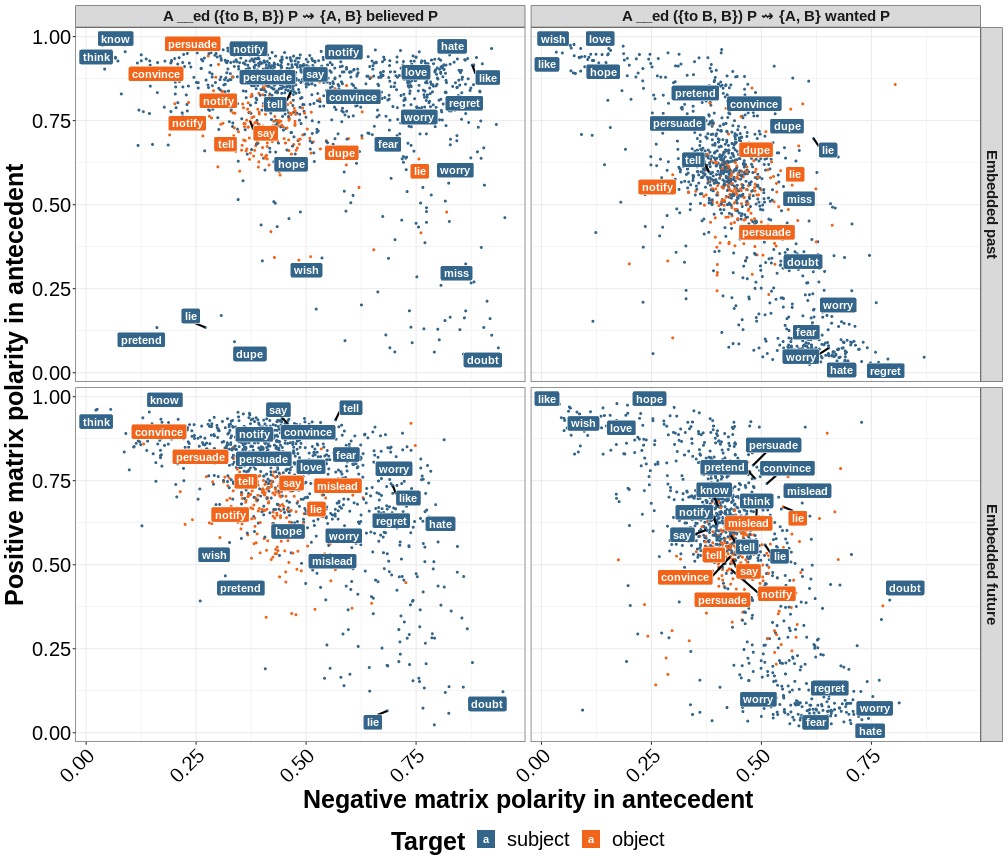

In [27]:
%%R -i mc_normalized_cast -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

mc_normalized_cast$target <- factor(mc_normalized_cast$target, levels=c('subject', 'object'))
mc_normalized_cast$consequent_embedded_tense <- factor(mc_normalized_cast$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'rejected', 'miss')
transitive_verbs = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe')

intransitive_frames = c('NP V that S', 'NP be V that S', 
                        'NP V that S[+future]', 'NP be V that S[+future]', 
                        'NP V that S[-tense]', 'NP be V that S[-tense]')

g <- ggplot(mc_normalized_cast, aes(x=negative, y=positive, color=target)) +
geom_point(size=0.75) +
geom_label_repel(data=filter(mc_normalized_cast, 
                       (antecedent_verb%in%intransitive_verbs & antecedent_frame %in% intransitive_frames) | (antecedent_verb%in%transitive_verbs & !(antecedent_frame %in% intransitive_frames))), 
           aes(label=antecedent_verb, fill=target), 
           color="white", fontface="bold", segment.color="black", segment.size=1) +
scale_color_manual(name='Target', values=c("#33658a", "#f26419")) +
scale_fill_manual(name='Target', values=c("#33658a", "#f26419")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', 'wanted'), 
                            ifelse(consequent_verb=='believe', 'P', 'P'))) +
xlab('Negative matrix polarity in antecedent') +
ylab('Positive matrix polarity in antecedent') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_distributions.png', width=14, height=12)
ggsave('plots/verb_distributions.pdf', width=14, height=12)

g

## Discovering inference patterns

Section 5 in the paper applies a multiview mixed effects mixture model to MegaIntensionality as well as two other datasets simultaneously. For each dataset, we define a `verbframe` column, which gives the verb-frame pairs to be clustered, and an `item` column, which gives the dimensions of the cluster centers.

In [28]:
mc['verbframe'] = mc.antecedent_verb + '-' + mc.antecedent_frame

mc['item'] = (mc.antecedent_polarity + '-' +
              mc.target + '-' +
              mc.consequent_verb)

In addition to MegaIntensionality, we use [MegaVeridicality](http://megaattitude.io/projects/mega-veridicality/), which captures veridicality inferences using 3-way ordinal judgments (_yes_, _maybe or maybe not_, _no_)...

In [29]:
mv = pd.read_csv('http://megaattitude.io/projects/mega-veridicality/mega-veridicality-v1/mega-veridicality-v1.csv')

mv = mv[mv.nativeenglish]
mv = mv[~mv.conditional]

mv['frame'] = mv.voice.map({'active': 'NP V that S', 'passive': 'NP be V that S'})
mv['verbframe'] = mv.verb + '-' + mv.frame

mv['item'] = mv.polarity

mv['response'] = mv.veridicality.astype(pd.CategoricalDtype(categories=['no', 'maybe', 'yes'])).cat.codes

mv

,participant,list,presentationorder,verb,frame,voice,polarity,conditional,veridicality,acceptability,nativeenglish,exclude,verbframe,item,response
0,219,0,1,surmise,NP V that S,active,positive,False,maybe,6,True,False,surmise-NP V that S,positive,1
1,219,0,2,update,NP V that S,active,positive,False,yes,2,True,False,update-NP V that S,positive,2
2,219,0,3,disregard,NP V that S,active,negative,False,maybe,4,True,False,disregard-NP V that S,negative,1
3,219,0,4,agree,NP V that S,active,positive,False,yes,4,True,False,agree-NP V that S,positive,2
4,219,0,5,surmise,NP V that S,active,negative,False,maybe,3,True,False,surmise-NP V that S,negative,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10875,78,15,64,exclaim,NP V that S,active,negative,False,maybe,1,True,False,exclaim-NP V that S,negative,1
10876,78,15,65,bitch,NP V that S,active,positive,False,yes,7,True,False,bitch-NP V that S,positive,2
10877,78,15,66,assure,NP be V that S,passive,negative,False,maybe,5,True,False,assure-NP be V that S,negative,1
10878,78,15,67,wow,NP be V that S,passive,negative,False,maybe,3,True,False,wow-NP be V that S,negative,1


...and [MegaNegRaising](http://megaattitude.io/projects/mega-negraising), which captures neg-raising inferences using a [0, 1] slider (like MegaIntensionality).

In [30]:
mn = pd.read_csv('http://megaattitude.io/projects/mega-negraising/mega-negraising-v1/mega-negraising-v1.tsv', sep='\t')

mn = mn[mn.frame.map(lambda x: 'that S' in x)]
mn = mn[mn.nativeenglish]

mn['verbframe'] = mn.verb + '-' + mn.frame

mn['item'] = mn.subject + '-' + mn.tense

mn['response'] = mn.negraising.map(lambda x: min(x, ONE)).map(lambda x: max(x, ZERO))

mn

,participant,list,presentationorder,verb,frame,tense,subject,sentence1,sentence2,negraising,acceptability,nativeenglish,verbframe,item,response
0,229,81,8,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.30,0.97,True,abhor-NP V that S,first-past,0.30000
1,259,81,15,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.09,0.34,True,abhor-NP V that S,first-past,0.09000
2,883,81,14,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.50,0.71,True,abhor-NP V that S,first-past,0.50000
3,665,81,22,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.00,0.87,True,abhor-NP V that S,first-past,0.00001
4,901,81,12,abhor,NP V that S,past,first,I didn't abhor that a particular thing happened.,I abhorred that that thing didn't happen.,0.33,0.61,True,abhor-NP V that S,first-past,0.33000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79335,742,200,11,yelp,NP V that S,past,third,A particular person didn't yelp that a particu...,That person yelped that that thing didn't happen.,0.14,0.84,True,yelp-NP V that S,third-past,0.14000
79336,1013,200,5,yelp,NP V that S,past,third,A particular person didn't yelp that a particu...,That person yelped that that thing didn't happen.,0.58,0.50,True,yelp-NP V that S,third-past,0.58000
79337,463,200,2,yelp,NP V that S,past,third,A particular person didn't yelp that a particu...,That person yelped that that thing didn't happen.,0.04,0.95,True,yelp-NP V that S,third-past,0.04000
79338,740,200,1,yelp,NP V that S,past,third,A particular person didn't yelp that a particu...,That person yelped that that thing didn't happen.,0.28,0.21,True,yelp-NP V that S,third-past,0.28000


### Combining the datasets

To make passing multiple datasets (with metadata) to the mixture model we define below, we use a lightweight dataclass.

In [31]:
@dataclass
class Data:
    dataframe: pd.DataFrame
    name: str
    datatype: str
        
data = [Data(mc, 'belief_desire', 'unit'), 
        Data(mv, 'veridicality', 'ordinal'),
        Data(mn, 'negraising', 'unit')]

### Multiview Mixed Effects Mixture Model

We define the multiview mixture model, which is initialized using a variant of $k$-means clustering that allows for missing data.

In [32]:
class KMeansWithMissingData:
    """K-Means for data with values missing
    
    Parameters
    ----------
    n_clusters
        The number of clusters.
    init
        How to initialize the model. Must be either "random" (default) 
        or "kmeans++".
    fuzzy_impute
        Whether to use hard (default) or fuzzy imputation when imputing 
        missing values during cluster center updates.
    random_state
        The random seed.
    """
    
    def __init__(self, n_clusters: int = 2, init: str="random", 
                 fuzzy_impute: bool = False, random_state: int = 42):
        self.n_clusters = n_clusters
        self.init_method = init
        self.fuzzy_impute = fuzzy_impute
        self.random_state = random_state
    
    def _initialize_cluster_centers(self):
        self.missing_patterns_, self.pattern_assignments_ = np.unique(self.missing_, 
                                                                      return_inverse=True,
                                                                      axis=0)
        self.observed_patterns_ = ~self.missing_patterns_
        
        self.X_binned_ = [self.X_[self.pattern_assignments_ == i] 
                          for i in range(self.missing_patterns_.shape[0])]
        
        X_synthesized = np.array([np.nanmean([b[np.random.choice(b.shape[0])]
                                              for b in self.X_binned_], axis=0) 
                                  for _ in range(self.X_.shape[0])])
        
        if self.init_method == "kmeans++":
            cluster_centers = np.array([X_synthesized[0]])

            for _ in range(self.n_clusters-1):
                dist = np.square(cluster_centers[:,None,:] -
                                 X_synthesized[None,:,:]).sum(axis=2)
                mindist = dist.min(axis=0)
                prob = mindist/mindist.sum()

                center = X_synthesized[np.random.choice(prob.shape[0], p=prob)]

                cluster_centers = np.concatenate([cluster_centers, [center]], axis=0)
                
        else:
            cluster_centers = X_synthesized[:self.n_clusters]

        self.cluster_centers_ = cluster_centers
    
    def _compute_cluster_assignments(self, X=None, cluster_centers=None):
        self.sqdist_to_center_ = self._compute_distances(X=X,
                                                         cluster_centers=cluster_centers)
        self.cluster_assignments_ = np.argmin(self.sqdist_to_center_, axis=0)
    
    def _compute_distances(self, X=None, cluster_centers=None):
        if X is None:
            X = self.X_
        
        if cluster_centers is None:
            cluster_centers = self.cluster_centers_
        
        return np.nansum(np.square(cluster_centers[:,None,:] - X[None,:,:]), 
                         axis=2)
    
    def _impute(self):
        if self.fuzzy_impute:
            weight = np.exp(-self.sqdist_to_center_)/\
                     np.exp(-self.sqdist_to_center_).sum(axis=0)[None,:]
            
            return np.where(self.missing_, 
                            np.sum(weight[:,:,None]*
                                   self.cluster_centers_[:,None,:], 
                                   axis=0), 
                            self.X_)
        else:
            return np.where(self.missing_, 
                            self.cluster_centers_[self.cluster_assignments_], 
                            self.X_)
    
    def fit(self, X: np.array, maxiter=1000):
        """Computes a modified version of Lloyd's algorithm

        The main difference between the standard version of Lloyd's algorithm 
        and the one computed here is that, when computing the distance between 
        a point and a cluster center, only the observed values for the point 
        are used; and when updating cluster centers, the missing values for 
        a point are first imputed based either on the current cluster assignment 
        (hard imputation) or as a weighted mean over a softmax on the negative 
        distances.

        Parameters
        ----------
        X
            The points to cluster
        maxiter
            The maximum number of EM iterations
        """
        self.X_ = X
        self.n_samples_, self.n_features_ = self.X_.shape
        
        # find the missing values
        self.missing_ = np.isnan(self.X_)
        self.observed_ = ~self.missing_
        
        # initialize cluster centers
        np.random.seed(self.random_state)
        self._initialize_cluster_centers()
        
        # initialize cluster assignments
        self._compute_cluster_assignments()
        
        for _ in range(maxiter):
            previous_cluster_assignments = self.cluster_assignments_

            # impute missing values based on current assignments
            Ximputed = self._impute()
            
            # update cluster centers
            for i in np.arange(self.n_clusters):
                Ximputed_i = Ximputed[self.cluster_assignments_ == i]
                self.cluster_centers_[i] = np.mean(Ximputed_i, axis=0)
                
            # update cluster assignments
            self._compute_cluster_assignments()
            
            # test change in cluster assignments
            cluster_assignment_unchanged = (previous_cluster_assignments ==
                                            self.cluster_assignments_)

            if cluster_assignment_unchanged.all():
                break
            
        else:
            warn(f'KMeansWithMissingData({self.n_clusters}) did not converge'
                 f' after {maxiter} iterations')
        
        return self
    
    def distances(self, X):
        return self._compute_distances(X=X)

Our multiview mixture model makes the following distributional assumptions:

$$\begin{align*}
\alpha &\sim \mathrm{log}\mathcal{N}\left(0, 100\right) \\
\boldsymbol\gamma &\sim \mathrm{Dirichlet}\left(\mathbf{1}_K\right) \\
\boldsymbol\theta_{\langle v, f \rangle} &\sim \mathrm{Dirichlet}\left(\alpha\boldsymbol\gamma\right) \\
c_i &\sim \mathrm{Categorical}\left(\boldsymbol\theta_{\left\langle\mathrm{verb}(i),\;\mathrm{frame}(i)\right\rangle}\right) \\
\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;c_i\right\rangle} & \sim \mathcal{N}(\mathbf{0}, 100\mathbf{I}) \\
y_i &\sim f_{\mathrm{view}(i)}\left(\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;c_i\right\rangle} \cdot \mathbf{x}_i, \boldsymbol\rho_{\mathrm{participant}(i)}\right) \\
\end{align*}$$

where $f_{\mathrm{view}(i)}$ is an ordinal mixed effects model for MegaVeridicality and a beta mixed effects model for MegaNegRaising and MegaIntensionality responses.

In [33]:
def hash_column(col: pd.Series, categories: Optional[List]=None) -> np.array:
    if categories is None:
        return torch.tensor(col.astype('category').cat.codes.values).type(torch.long)
    else:
        return torch.tensor(col.astype(pd.CategoricalDtype(categories=categories)).cat.codes.values).type(torch.long)


class MultiviewMixedEffectsMixtureModel:
    """A multiview mixed effects mixture model
    
    Parameters
    ----------
    data
        The list of datasets containing the objects to cluster
    n_components
        The number of clusters to assume
    component_dispersion
        A scaling term for the parameter of a dirichlet distribution on the by-verb 
        component probabilities. If infer_weight_component_dispersion is True, this 
        is treated as the mean of the normal distribution underlying a log-normal 
        prior on this parameter.
    infer_weight_component_dispersion
        Whether to place a log-normal prior on the component dispersion.
    infer_weight_mean
        Whether to place a uniform dirichlet hyperprior on the mean of the dirichlet 
        distribution on the by-verb component probabilities.
    seed
        The random seed
    """
    required_columns = ['verbframe', 'item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, data: List[Data], n_components: int, component_dispersion: float = 1.,
                 infer_weight_component_dispersion: bool = True, infer_weight_mean: bool = True, 
                 location_precision: float = 1., 
                 seed: int = 42):
        self._n_components = n_components
        self._component_dispersion = component_dispersion
        self._location_variance = 1/location_precision
        
        self._seed = seed
        
        self._infer_weight_component_dispersion = infer_weight_component_dispersion
        self._infer_weight_mean = infer_weight_mean
        
        self._data = {'train': {}, 'test': {}}
        self._datatypes = {'train': {}, 'test': {}}
        
        for d in data:
            self._validate_data(d)
        
        self._get_categories(data)
        
        self._construct_initialization(data)
    
    def _validate_data(self, data: Data) -> None:
        for col in self.required_columns:
            if col not in data.dataframe.columns:
                raise ValueError(f'"{col}" column is required in {data.name}_data')

    def _get_verbframe(self, data: List[Data]) -> None:
        self._verbframe = set()
        
        for d in data:
            self._verbframe |= set(d.dataframe.verbframe.unique())
        
        self._verbframe = sorted(self._verbframe)
        self._n_verbframe = len(self._verbframe)
        
    def _get_categories(self, data):
        self._get_verbframe(data)
        
        self._categories = {d.name: {col: sorted(d.dataframe[col].unique()) 
                                     for col in self.required_columns 
                                     if col != 'response' or d.datatype in ['nominal', 'ordinal']} 
                            for d in data}
                
    def _prepare_data(self, data: List[Data], split: str='train') -> None:
        self._raw_data = data
        
        for d in data:
            self._validate_data(d)            
        
        for d in data:
            self._datatypes[split][d.name] = d.datatype
            
            columns = self._data[split][d.name] = {}
            
            for col in self.required_columns:
                if col == 'response':
                    columns[col] = torch.tensor(d.dataframe[col].values).type(torch.float)
                    columns[f'n_{col}'] = d.dataframe.shape[0]
                    
                elif col == 'verbframe':
                    columns[col] = hash_column(d.dataframe[col], self._verbframe)
                    columns[f'n_{col}'] = self._n_verbframe
                    
                else:
                    columns[col] = hash_column(d.dataframe[col], self._categories[d.name][col])
                    columns[f'n_{col}'] = len(self._categories[d.name][col])
    
    def _init_loc_fn(self, site):        
        if site["name"] in self._initialization:
            return torch.tensor(self._initialization[site["name"]]).type(torch.float)
        
        return init_to_uniform(site, radius=1e-3)
    
    def _construct_initialization(self, data):
        self._initialization = {}
        
        colcounts = {}
        
        for i, d in enumerate(data):
            if d.datatype == 'ordinal':
                mid = np.median(self._categories[d.name]['response'])
            elif d.datatype == 'unit':
                mid = 0.5
            
            dm = d.dataframe.pivot_table(index='verbframe',
                                         columns='item',
                                         values='response')
            
            if d.datatype == 'ordinal':
                # center values
                dm = dm - mid
            elif d.datatype == 'unit':
                dm = np.log(dm.clip(ZERO, ONE)) - np.log(1-dm.clip(ZERO, ONE))
            
            colcounts[d.name] = len(dm.columns)
            
            if i:
                data_means = pd.merge(data_means, dm, 
                                      left_index=True, right_index=True, 
                                      how='outer')

            else:
                data_means = dm
        
        kmeans = KMeansWithMissingData(self._n_components,
                                       init="kmeans++",
                                       random_state=self._seed)
        kmeans.fit(data_means.loc[self._verbframe].values)
    
        self._initialization['weights'] = (np.exp(-kmeans.sqdist_to_center_)/
                                           np.exp(-kmeans.sqdist_to_center_).sum(axis=0)[None,:]).T
        self._initialization['weights'] = (self._initialization['weights'] + ZERO)/\
                                          (self._initialization['weights'] + ZERO).sum(axis=1)[:,None]
        
        left_col_idx = 0
        
        for d in data:
            right_col_idx = left_col_idx + colcounts[d.name]
            self._initialization[f'{d.name}_locs'] = kmeans.cluster_centers_[:, left_col_idx:right_col_idx]
            left_col_idx = right_col_idx
    
    def _initialize_model(self):
        model_dict = {'global': self._initialize_global_parameters()}
        
        hide = []
        
        for name, dtype in self._datatypes['train'].items():
            hide.append(f'{name}_assignment')
            
            if dtype == 'unit':
                model_dict[name] = self._initialize_unit_model(name)
                
            elif dtype == 'ordinal':
                hide.append(f'{name}_obs')
                hide.append(f'{name}_response')
                model_dict[name] = self._initialize_ord_model(name)
        
        @config_enumerate
        def model(data):
            model_dict['global']()
            
            log_probs = {}
            
            for name, m in model_dict.items():
                if name != 'global':
                    log_probs[name] = m(**data[name])
                    
            return log_probs
            
        guide = AutoDelta(poutine.block(model, hide=hide), 
                          init_loc_fn=self._init_loc_fn)
        
        return model, guide

    def _initialize_global_parameters(self):
        def model():
            if self._infer_weight_component_dispersion:
                component_dispersion = pyro.sample(f'weight_component_dispersion', 
                                                   dist.LogNormal(np.log(self._component_dispersion),
                                                                  self.large_variance))
            else:
                component_dispersion = self._component_dispersion
            
            if self._infer_weight_mean:
                theta = pyro.sample('weight_mean',
                                    dist.Dirichlet(torch.ones(self._n_components)))
                theta = self._n_components * theta
            else:
                theta = torch.ones(self._n_components)
                
            with pyro.plate('verb_plate', self._n_verbframe):
                self._weights = pyro.sample('weights',
                                            dist.Dirichlet(component_dispersion*theta))
                
        return model
    
    def _initialize_unit_model(self, name):
        
        def model(verbframe, item, participant, response, 
                  n_verbframe, n_item, n_participant, n_response):
            scale = pyro.sample(f'{name}_scale', dist.LogNormal(0., self.large_variance))
            
            locs_variance = pyro.sample(f'{name}_variance', 
                                        dist.LogNormal(np.log(self._location_variance),
                                                       self.large_variance))
            
            scales_participant_scale = pyro.sample(f'{name}_scales_participant_scale', 
                                                   dist.LogNormal(0., self.large_variance))
            locs_participant_scale = pyro.sample(f'{name}_locs_participant_scale', 
                                                 dist.LogNormal(0., self.large_variance))
            
            with pyro.plate(f'{name}_component_plate', self._n_components):
                locs = pyro.sample(f'{name}_locs', 
                                   dist.MultivariateNormal(torch.zeros(n_item),
                                                           locs_variance*torch.eye(n_item)))
            
            with pyro.plate(f'{name}_participant', n_participant):
                scales_participant = pyro.sample(f'{name}_scales_participant',
                                                 dist.LogNormal(0., scales_participant_scale))
                locs_participant = pyro.sample(f'{name}_locs_participant',
                                               dist.Normal(0., locs_participant_scale))

            with pyro.plate(f'{name}_response', n_response):
                assignment = pyro.sample(f'{name}_assignment', 
                                         dist.Categorical(self._weights[verbframe]),
                                        infer={"enumerate": "parallel"})
                
                locs = torch.sigmoid(locs[assignment, item] +\
                                     locs_participant[participant])
                
                scales = scale + scales_participant[participant]
                
                concentration1 = scales*locs
                concentration0 = scales*(1.-locs)

                pyro.sample(f'{name}_obs', 
                            dist.Beta(concentration1, concentration0), 
                            obs=response)
                
                lp = dist.Beta(concentration1.clamp(min=ZERO), 
                               concentration0.clamp(min=ZERO)).log_prob(response)
                
                return lp
                
        return model
    
    def _initialize_ord_model(self, name):
        def model(verbframe, item, participant, response,
                  n_verbframe, n_item, n_participant, n_response):
            n_response_types = len(self._categories[name]['response'])

            shift = pyro.sample(f'{name}_shift', 
                                dist.Normal(0., self.large_variance))
    
            locs_variance = pyro.sample(f'{name}_variance', 
                                        dist.LogNormal(np.log(self._location_variance),
                                                       self.large_variance))
    
            with pyro.plate(f'{name}_component_plate', self._n_components):
                locs = pyro.sample(f'{name}_locs',
                                     dist.MultivariateNormal(torch.zeros(n_item),
                                                             locs_variance*torch.eye(n_item)))

            with pyro.plate('participant_plate', n_participant):
                jumps_participant_mean = torch.zeros(n_response_types - 1)
                jumps_participant = pyro.sample(f'{name}_jumps_participant',
                                                dist.MultivariateNormal(jumps_participant_mean, 
                                                                        self.large_variance*torch.eye(n_response_types - 1)))
                
            cuts_participant = torch.cumsum(torch.exp(jumps_participant), axis=1)
            cuts_participant = cuts_participant - torch.mean(cuts_participant)

            with pyro.plate(f'{name}_response', n_response):
                
                assignment = pyro.sample(f'{name}_assignment', 
                                         dist.Categorical(self._weights[verbframe]),
                                         infer={"enumerate": "parallel"})
                
                values = torch.cat((n_response_types - 1)*[locs[assignment,item].unsqueeze(-1)], axis=-1)
                
                cdf = torch.sigmoid(cuts_participant[participant] - values)
                cdf_pad_shape = list(cdf.shape[:-1])+[1]
                cdf_high = torch.cat([cdf, torch.ones(cdf_pad_shape)], axis=-1)
                cdf_low = torch.cat([torch.zeros(cdf_pad_shape), cdf], axis=-1)

                pmf = cdf_high - cdf_low

                pyro.sample('obs', dist.Categorical(probs=pmf), obs=response)

                lp = dist.Categorical(probs=pmf).log_prob(response)

        return model
    
    def fit(self, data: List[Data], lr: float = 0.05, tolerance=0.0005, window_size=100,
            iterations: int=10000, patience: int = 1000, verbosity: int=100) -> 'MultiviewMixtureModel':
        pyro.set_rng_seed(self._seed)
        pyro.clear_param_store()
        
        for d in data:
            self._prepare_data(data, split='train')
        
        optim = pyro.optim.Adam({'lr': lr})
        self._elbo = TraceEnum_ELBO(max_plate_nesting=1)
        
        self._model, self._guide = self._initialize_model()
        
        svi = SVI(self._model, self._guide, optim, loss=self._elbo)
        
        losses = []
         
        like_hist = []
        prev_like_sum = -np.inf
            
        for i in range(iterations):
            
            loss = svi.step(self._data['train'])
            losses.append(loss)
            
            like = self.likelihood(data)
            
            like_sum = sum(list(like.values()))
            like_sum_abs = np.sum([abs(l) for l in like.values()])
            
            like_hist = like_hist[1:] if len(like_hist) > window_size else like_hist
            
            if i:
                like_hist.append((like_sum-prev_like_sum)/like_sum_abs)
                
                if np.mean(like_hist) > tolerance:
                    prev_like_sum = like_sum
                elif i > patience:
                    print(like)
                    #print(np.mean(like_hist))
                    break
                    
            else:
                prev_like_sum = like_sum
            
            if not i % verbosity:
                print(like)
                print()
        
        return self, i, np.isnan(loss)
    
    def param(self, param_name):
        return pyro.get_param_store()[f'AutoDelta.{param_name}']
    
    def likelihood(self, data: List[Data]):
        self._prepare_data(data, split='test')
        
        likes = {}
        
        for name, dt in self._datatypes['test'].items():
            if dt == 'unit':
                likes[name] = self._unit_likelihood(name)
            elif dt == 'ordinal':
                likes[name] = self._ord_likelihood(name)
                
        return likes
        
    def _unit_likelihood(self, name):
        data = self._data['test'][name]
        
        weights = self.param('weights')[data['verbframe']]
        
        scale_fixed = self.param(f'{name}_scale')
        locs_fixed = self.param(f'{name}_locs')

        scales_participant = self.param(f'{name}_scales_participant')
        locs_participant = self.param(f'{name}_locs_participant')

        locs = torch.sigmoid(locs_fixed[:, data['item']] +\
                             locs_participant[data['participant']])

        scales = scale_fixed + scales_participant[data['participant']]

        concentration1 = scales*locs
        concentration0 = scales*(1.-locs)

        logprob = dist.Beta(concentration1.clamp(min=ZERO), 
                            concentration0.clamp(min=ZERO)).log_prob(data['response'])
        
        return (weights * logprob.T).data.numpy().sum()
    
    def _ord_likelihood(self, name):
        data = self._data['test'][name]
        response = data['response']
        
        weights = self.param('weights')[data['verbframe']]
        
        n_response_types = len(self._categories[name]['response'])
        
        locs = self.param(f'{name}_locs')

        jumps_participant = self.param(f'{name}_jumps_participant')
    
        cuts_participant = torch.cumsum(torch.exp(jumps_participant), axis=1)
        cuts_participant = cuts_participant - torch.mean(cuts_participant)
        
        values = torch.cat((n_response_types - 1)*[locs[:,data['item']].unsqueeze(-1)], axis=-1)
                
        cdf = torch.sigmoid(cuts_participant[data['participant']] - values)
        cdf_pad_shape = list(cdf.shape[:-1])+[1]
        cdf_high = torch.cat([cdf, torch.ones(cdf_pad_shape)], axis=-1)
        cdf_low = torch.cat([torch.zeros(cdf_pad_shape), cdf], axis=-1)

        pmf = cdf_high - cdf_low

        logprob = dist.Categorical(probs=pmf).log_prob(data['response'])
        
        return (weights * logprob.T).data.numpy().sum()

We fit this model with numbers of clusters between 2 and 20.

In [34]:
models = {}
parameters = {}

for n_components in range(2, 21):
    print()
    print(f'Fitting model with {n_components} components...')
    print()
    
    models[n_components] = MultiviewMixedEffectsMixtureModel(data, n_components, seed=403921)
    models[n_components].fit(data, lr=0.01, tolerance=1e-6, iterations=10000, patience=1000, verbosity=100)
    
    parameters[n_components] = {'weights': pd.DataFrame(models[n_components].param('weights').data.numpy(), 
                                                        index=models[n_components]._verbframe),
                                'belief_desire_locs': pd.DataFrame(models[n_components].param('belief_desire_locs').data.numpy(),
                                                                   columns=mc.item.astype('category').cat.categories).T,
                                'veridicality_locs': pd.DataFrame(models[n_components].param('veridicality_locs').data.numpy(),
                                                                  columns=mv.item.astype('category').cat.categories).T,
                                'negraising_locs': pd.DataFrame(models[n_components].param('negraising_locs').data.numpy(),
                                                                  columns=mn.item.astype('category').cat.categories).T,
                                'belief_desire_scale': float(models[n_components].param('belief_desire_scale').data.numpy()),
                                'veridicality_jumps_participant': models[n_components].param('veridicality_jumps_participant').data.numpy(),
                                'negraising_scale': float(models[n_components].param('negraising_scale').data.numpy())}
    
    print()
    print('=====================================================================================')


Fitting model with 2 components...

{'belief_desire': 58893.277, 'veridicality': -11002.066, 'negraising': 10986.236}

{'belief_desire': 81047.875, 'veridicality': -8216.194, 'negraising': 28685.453}

{'belief_desire': 84921.35, 'veridicality': -7698.567, 'negraising': 32867.1}

{'belief_desire': 85251.29, 'veridicality': -7594.0527, 'negraising': 34539.684}

{'belief_desire': 85316.4, 'veridicality': -7564.7637, 'negraising': 34999.2}

{'belief_desire': 85350.445, 'veridicality': -7554.8086, 'negraising': 35141.6}

{'belief_desire': 85365.56, 'veridicality': -7549.9824, 'negraising': 35203.97}

{'belief_desire': 85371.14, 'veridicality': -7546.8516, 'negraising': 35238.664}

{'belief_desire': 85374.266, 'veridicality': -7544.108, 'negraising': 35259.51}

{'belief_desire': 85375.96, 'veridicality': -7541.5493, 'negraising': 35272.008}

{'belief_desire': 85377.125, 'veridicality': -7539.5596, 'negraising': 35279.367}

{'belief_desire': 85377.17, 'veridicality': -7539.5103, 'negraising'

{'belief_desire': 94092.93, 'veridicality': -6907.734, 'negraising': 35521.19}

{'belief_desire': 94457.69, 'veridicality': -6890.465, 'negraising': 35559.87}

{'belief_desire': 94686.805, 'veridicality': -6881.814, 'negraising': 35579.777}

{'belief_desire': 94840.37, 'veridicality': -6877.789, 'negraising': 35590.652}

{'belief_desire': 94953.3, 'veridicality': -6874.3203, 'negraising': 35595.53}

{'belief_desire': 95042.56, 'veridicality': -6870.4746, 'negraising': 35597.15}

{'belief_desire': 95125.234, 'veridicality': -6867.8726, 'negraising': 35597.355}

{'belief_desire': 95197.9, 'veridicality': -6865.6196, 'negraising': 35596.47}

{'belief_desire': 95253.13, 'veridicality': -6864.7393, 'negraising': 35595.082}

{'belief_desire': 95312.14, 'veridicality': -6864.752, 'negraising': 35593.766}

{'belief_desire': 95359.64, 'veridicality': -6863.1753, 'negraising': 35591.39}

{'belief_desire': 95402.13, 'veridicality': -6861.8677, 'negraising': 35588.36}

{'belief_desire': 95445.734,

{'belief_desire': 67687.6, 'veridicality': -10845.042, 'negraising': 11569.58}

{'belief_desire': 72236.49, 'veridicality': -7867.8735, 'negraising': 28365.992}

{'belief_desire': 83275.99, 'veridicality': -7171.495, 'negraising': 33134.82}

{'belief_desire': 87501.81, 'veridicality': -6990.486, 'negraising': 34848.707}

{'belief_desire': 89899.64, 'veridicality': -6929.415, 'negraising': 35282.48}

{'belief_desire': 91963.74, 'veridicality': -6894.5205, 'negraising': 35442.17}

{'belief_desire': 93730.15, 'veridicality': -6863.9966, 'negraising': 35525.14}

{'belief_desire': 94980.695, 'veridicality': -6834.5767, 'negraising': 35573.105}

{'belief_desire': 95788.35, 'veridicality': -6812.075, 'negraising': 35596.633}

{'belief_desire': 96344.41, 'veridicality': -6789.132, 'negraising': 35610.082}

{'belief_desire': 96746.8, 'veridicality': -6761.6655, 'negraising': 35616.875}

{'belief_desire': 96992.33, 'veridicality': -6733.558, 'negraising': 35620.805}

{'belief_desire': 97132.34, 

{'belief_desire': 97833.414, 'veridicality': -6549.3804, 'negraising': 35658.72}


Fitting model with 17 components...

{'belief_desire': 68223.586, 'veridicality': -10802.829, 'negraising': 11643.142}

{'belief_desire': 69990.63, 'veridicality': -7778.697, 'negraising': 28250.387}

{'belief_desire': 77971.88, 'veridicality': -7054.0723, 'negraising': 33162.74}

{'belief_desire': 83283.51, 'veridicality': -6847.4756, 'negraising': 34902.24}

{'belief_desire': 85801.16, 'veridicality': -6762.455, 'negraising': 35322.97}

{'belief_desire': 88775.89, 'veridicality': -6705.5034, 'negraising': 35484.984}

{'belief_desire': 92084.29, 'veridicality': -6655.8984, 'negraising': 35585.73}

{'belief_desire': 94719.68, 'veridicality': -6614.24, 'negraising': 35643.86}

{'belief_desire': 96200.586, 'veridicality': -6587.6104, 'negraising': 35674.043}

{'belief_desire': 96828.05, 'veridicality': -6576.688, 'negraising': 35691.97}

{'belief_desire': 97106.59, 'veridicality': -6573.499, 'negraising': 

We use the soft clustering derived from our multiview mixed effects mixture model to predict verbs' distributions. Specifically, for each verb $v$, we use $\boldsymbol\phi_v$ such that $\phi_{vk} = 1 - \prod_f 1 - \theta_{\langle v, f\rangle k}$. 

In [35]:
for n_components, ps in parameters.items():

    component_probs = ps['weights']
    component_probs = component_probs.reset_index()
    component_probs = component_probs.rename(columns = {'index':'verbframe'})
    component_probs[['verb', 'frame']] = component_probs['verbframe'].str.split('-', 1, expand=True)
    component_probs = component_probs.drop(columns=['verbframe'])

    ps['component_probs'] = component_probs

    component_probs_any = component_probs.pivot_table(index='verb', 
                                                      values=list(range(n_components)),
                                                      aggfunc=lambda x: 1-np.prod(1-x))

    ps['component_probs_any'] = component_probs_any
    
parameters[2]['component_probs_any']

,0,1
verb,,
abhor,1.000000,0.000000
accept,0.000000,1.000000
acclaim,0.000000,1.000000
acknowledge,0.000000,1.000000
add,0.000000,1.000000
...,...,...
wow,0.333781,0.666219
write,0.000000,1.000000
yearn,0.000000,1.000000


As our measure of syntactic distribution, we use the normalized version of the [MegaAcceptability](http://megaattitude.io/projects/mega-acceptability/) dataset.

In [36]:
ma = pd.read_csv('http://megaattitude.io/projects/mega-acceptability/mega-acceptability-v1/mega-acceptability-v1-normalized.tsv', sep='\t')

ma

,verb,verbform,frame,sentence,responsenorm,responsevar
0,abhor,abhorred,NP Ved,Someone abhorred .,0.937020,-2.288458
1,abhor,abhorred,NP Ved NP,Someone abhorred something .,1.757018,-1.554375
2,abhor,abhorred,NP Ved NP VP,Someone abhorred someone do something .,-1.728826,-1.018119
3,abhor,abhorred,NP Ved NP VPing,Someone abhorred someone doing something .,1.018668,-1.245996
4,abhor,abhorred,NP Ved NP that S,Someone abhorred someone that something happen...,-0.595499,-0.585704
...,...,...,...,...,...,...
50345,refuse,refused,NP was Ved whether S[+future],Someone was refused whether something would ha...,-0.840208,-1.110817
50346,refuse,refused,NP was Ved whether to VP,Someone was refused whether to do something .,-0.522459,-1.057192
50347,refuse,refused,NP was Ved whichNP S,Someone was refused which thing happened .,-1.826966,-0.228580
50348,refuse,refused,NP was Ved whichNP to VP,Someone was refused which thing to do .,-0.682572,-1.059557


In [37]:
ma_cast = ma.pivot_table(index='verb', columns='frame', values='responsenorm')

ma_cast

frame,NP Ved,NP Ved NP,NP Ved NP VP,NP Ved NP VPing,NP Ved NP that S,NP Ved NP that S[+future],NP Ved NP that S[-tense],NP Ved NP to NP,NP Ved NP to VP[+eventive],NP Ved NP to VP[-eventive],...,NP was Ved that S[+future],NP was Ved that S[-tense],NP was Ved to VP[+eventive],NP was Ved to VP[-eventive],NP was Ved whether S,NP was Ved whether S[+future],NP was Ved whether to VP,NP was Ved whichNP S,NP was Ved whichNP to VP,"S, I V"
verb,,,,,,,,,,,,,,,,,,,,,
abhor,0.937020,1.757018,-1.728826,1.018668,-0.595499,-1.710499,-1.373725,-0.151609,-0.970789,-0.575904,...,0.164902,0.284888,0.482186,0.197919,-0.195694,0.337812,0.177505,0.362723,-0.967037,0.135286
absolve,-0.663034,1.145783,-0.666244,-0.186460,-0.113224,-1.373725,-0.096106,-0.640620,-0.300382,-0.155661,...,-0.036710,-0.172364,-0.325584,-0.754879,0.214287,-0.175035,-0.354602,-0.802287,-0.942693,-0.574568
accept,3.408551,2.302293,-0.177098,2.355586,-1.155363,-1.335952,-0.889221,-0.434964,0.722037,0.292264,...,-0.229893,-0.342262,0.718703,0.448758,-0.278486,-0.917158,-0.041599,-0.371269,-0.221968,1.196415
acclaim,0.787558,1.534969,-1.524099,0.749058,-1.574656,-0.819817,-1.679829,1.100519,-0.715073,-0.767939,...,-0.649803,-0.836003,-0.044266,0.803186,-0.600169,-1.289758,-0.567637,-0.471043,-1.909964,-0.218731
accredit,-0.146072,1.021509,-0.688883,0.177532,-1.242959,0.572064,-1.255702,2.689353,-1.051199,0.737418,...,-0.691179,-0.777956,0.756213,0.934650,-0.211424,-0.628762,-0.363196,-0.981960,-1.089276,-0.087709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
write,1.127889,3.158144,1.066073,0.627767,1.993645,1.405902,0.723277,4.265943,0.146673,0.975779,...,-0.972520,-1.075251,-0.019699,0.346763,-0.696586,-0.591181,-0.758885,-2.308244,-0.936538,1.746800
yawn,2.273459,-0.017889,-0.849888,-1.790265,-1.649073,-1.239552,-1.253520,-0.097707,-1.065610,-2.483755,...,-1.120533,-1.761810,-2.628754,-1.628078,-1.822994,-2.293340,-1.727873,-1.553524,-0.717280,0.399846
yearn,1.925214,0.634190,-0.560154,-0.556584,-1.267911,-1.938627,-1.348493,-0.569622,0.695818,-0.860978,...,-0.993025,-0.326606,-1.532523,-1.632808,-1.161706,-1.158492,-0.716224,-1.462843,-1.845160,0.375853


We regress the normalized acceptability for each predicate $v$ in MegaAcceptability on $\bm\phi_v$s using multivariate ridge regression. To evaluate the performance of this regression on data the model hasn't seen before, we use a separate outer 10-fold cross-validation. We then compute the by-item squared errors.

In [38]:
np.random.seed(2039486)

errors = defaultdict(list)

ma_cast = ma_cast.sort_values('NP Ved')
ma_cast = ma_cast.sample(frac=1, replace=False)

for i, (n_components, ps) in enumerate(parameters.items()):
    print(f'Fitting models with {n_components} components...')
    
    shared_index = ma_cast.index.intersection(ps['component_probs_any'].index)
    
    X = ps['component_probs_any'].loc[shared_index]
    Y = ma_cast.loc[shared_index]

    total_variance = Y.values.var()
    
    kf = KFold(n_splits=10, shuffle=False)
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        mod = RidgeCV(alphas=[0.001, 0.1, 0.2, 0.5, 1., 2., 5., 10.], cv=5).fit(X_train, Y_train)
        Y_test_pred = mod.predict(X_test)
    
        e = np.square(Y_test.to_numpy() - Y_test_pred)
        errors[n_components].append(e.tolist())
    
    errors[n_components] = np.concatenate(errors[n_components], axis=0)
    
    ci = np.quantile([np.mean(np.random.choice(errors[n_components].flatten(), 
                                               size=len(errors[n_components].flatten()), 
                                               replace=True))
                      for _ in range(999)], [0.025/(i+1), 0.5, 1.-0.025/(i+1)])
    
    r2 = np.round(1-ci/total_variance, 3)
    
    print()
    print(f'R2: {r2[1]}, 95%CI = [{r2[2]}, {r2[0]}]')
    print()

Fitting models with 2 components...

R2: 0.281, 95%CI = [0.27, 0.292]

Fitting models with 3 components...

R2: 0.282, 95%CI = [0.269, 0.295]

Fitting models with 4 components...

R2: 0.315, 95%CI = [0.301, 0.329]

Fitting models with 5 components...

R2: 0.323, 95%CI = [0.311, 0.337]

Fitting models with 6 components...

R2: 0.326, 95%CI = [0.311, 0.339]

Fitting models with 7 components...

R2: 0.32, 95%CI = [0.306, 0.333]

Fitting models with 8 components...

R2: 0.312, 95%CI = [0.296, 0.326]

Fitting models with 9 components...

R2: 0.321, 95%CI = [0.305, 0.336]

Fitting models with 10 components...

R2: 0.325, 95%CI = [0.311, 0.34]

Fitting models with 11 components...

R2: 0.327, 95%CI = [0.313, 0.342]

Fitting models with 12 components...

R2: 0.326, 95%CI = [0.312, 0.339]

Fitting models with 13 components...

R2: 0.332, 95%CI = [0.315, 0.347]

Fitting models with 14 components...

R2: 0.331, 95%CI = [0.317, 0.346]

Fitting models with 15 components...

R2: 0.337, 95%CI = [0.32

We then choose the optimal number of clusters as the minimal number of clusters such that no model with a greater number of clusters performs reliably better in terms of by-item squared error.

In [39]:
curr_n_components = min(errors)
curr_best = True
n_tests = 0

while True:
    for n_components in range(curr_n_components+1, max(errors)+1):
    #for n_components in range(curr_n_components+1, 21):
        diff_mse = errors[n_components] - errors[curr_n_components]

        alpha = 0.025/(n_tests+1)
        
        ci = np.quantile([np.mean(np.random.choice(diff_mse.flatten(), 
                                                   size=len(diff_mse.flatten()),
                                                   replace=True))
                          for _ in range(999)], [alpha, 0.5, 1.-alpha])

        n_tests += 1

        if ci[2] < 0:
            ci = np.round(ci, 3)
            print(f'Model with {n_components} components outperforms '
                  f'model with {curr_n_components} components')
            print(f'Difference in MSE: {ci[1]}, 95%CI=[{ci[0]}, {ci[2]}], alpha={np.round(alpha, 5)}')
            print()
            curr_n_components += 1
            break

    else:
        print()
        print(f'The model with {curr_n_components} components is the optimal model.')
        
        best_n_components = curr_n_components
        best_model = parameters[curr_n_components]
        break      

Model with 4 components outperforms model with 2 components
Difference in MSE: -0.055, 95%CI=[-0.063, -0.048], alpha=0.0125

Model with 4 components outperforms model with 3 components
Difference in MSE: -0.054, 95%CI=[-0.061, -0.047], alpha=0.00833

Model with 5 components outperforms model with 4 components
Difference in MSE: -0.014, 95%CI=[-0.019, -0.008], alpha=0.00625

Model with 13 components outperforms model with 5 components
Difference in MSE: -0.013, 95%CI=[-0.023, -0.004], alpha=0.00208

Model with 15 components outperforms model with 6 components
Difference in MSE: -0.017, 95%CI=[-0.026, -0.005], alpha=0.00119

Model with 11 components outperforms model with 7 components
Difference in MSE: -0.012, 95%CI=[-0.02, -0.002], alpha=0.001

Model with 9 components outperforms model with 8 components
Difference in MSE: -0.013, 95%CI=[-0.019, -0.007], alpha=0.00096

Model with 11 components outperforms model with 9 components
Difference in MSE: -0.01, 95%CI=[-0.02, -0.003], alpha=0.0

To investigate the verb-frame pairs that fall into each cluster, we look at pairs that have probability 1 for that cluster. 

In [40]:
for i in range(best_n_components):
    print(f'Verbs with highest weight for component {i}')
    print(best_model['weights'][best_model['weights'][i]==1].index)
    print()
    
best_model['weights']

Verbs with highest weight for component 0
Index(['aggravate-NP be V that S', 'agonize-NP V that S[+future]',
       'alarm-NP be V that S', 'alert-NP V that S', 'anger-NP be V that S',
       'anguish-NP V that S', 'annoy-NP be V that S', 'apologize-NP V that S',
       'bitch-NP V to NP that S', 'complain-NP V to NP that S',
       'crush-NP be V that S', 'cry-NP V that S', 'cry-NP V to NP that S',
       'curse-NP V that S', 'curse-NP V to NP that S', 'daunt-NP be V that S',
       'depress-NP be V that S', 'depress-NP be V that S[+future]',
       'despise-NP V that S', 'detest-NP V that S[+future]',
       'devastate-NP be V that S', 'devastate-NP be V that S[+future]',
       'disappoint-NP V that S', 'discourage-NP be V that S',
       'disgrace-NP be V that S', 'disgrace-NP be V that S[+future]',
       'disgust-NP be V that S', 'disgust-NP be V that S[+future]',
       'dislike-NP V that S', 'displease-NP be V that S',
       'dissatisfy-NP be V that S', 'distress-NP be V that 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
abhor-NP V that S,5.123972e-23,4.760753e-22,1.609006e-14,1.970580e-25,1.794850e-25,7.505835e-25,4.789973e-22,1.550063e-25,8.698432e-08,9.816792e-25,2.861605e-25,7.861039e-25,8.999357e-26,6.844294e-24,9.999999e-01
abhor-NP V that S[+future],5.199489e-21,5.168684e-19,2.354682e-18,1.162114e-24,4.164328e-24,1.842687e-23,1.755197e-20,3.538779e-24,1.000000e+00,3.732623e-24,7.016847e-24,1.929838e-23,2.145936e-24,1.413857e-22,1.777617e-18
abhor-NP be V that S,4.683872e-14,2.649728e-22,3.586101e-22,1.595046e-25,9.777179e-25,4.399380e-24,1.476382e-23,8.358207e-25,1.000000e+00,5.769498e-25,1.675802e-24,4.518576e-24,4.712521e-25,2.214317e-24,5.368117e-15
accept-NP V that S,2.859076e-23,2.659773e-23,3.854078e-24,1.202256e-23,1.420122e-22,1.000000e+00,2.419858e-23,5.137417e-16,2.632629e-23,3.974994e-24,1.136703e-23,2.742550e-23,2.920267e-21,4.597777e-24,2.196726e-23
accept-NP V that S[+future],8.745274e-24,8.794989e-24,1.635870e-17,1.398122e-21,8.067050e-22,1.000000e+00,1.462436e-23,9.919564e-13,1.092202e-23,3.812217e-23,1.369865e-23,8.840129e-24,2.688259e-18,2.148995e-21,1.184019e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yell-NP V to NP that S,3.093698e-24,3.159665e-24,4.859224e-16,1.536327e-10,1.000000e+00,2.475224e-21,1.206838e-23,3.862282e-21,3.768103e-24,8.603233e-22,1.054950e-22,3.140152e-24,1.400040e-18,1.924349e-21,1.102575e-23
yell-NP V to NP that S[+future],1.452456e-24,1.461008e-24,1.000000e+00,1.373006e-09,1.117882e-20,6.471750e-23,2.286833e-22,5.689253e-22,4.152779e-24,2.119867e-17,5.935056e-22,1.953949e-24,1.497050e-21,3.919407e-22,2.267436e-22
yelp-NP V that S,7.939472e-21,6.954501e-21,1.745435e-14,3.753859e-15,1.008024e-15,7.334493e-22,6.189403e-21,1.418265e-21,6.950920e-21,1.000000e+00,2.727185e-21,6.793892e-21,6.033673e-22,3.446742e-17,3.474758e-12
yelp-NP V that S[+future],1.869863e-24,2.186625e-24,1.865605e-10,1.000000e+00,3.140394e-22,5.195677e-23,7.679097e-22,2.266788e-21,5.058561e-23,1.299311e-21,3.294583e-23,1.827035e-24,1.828342e-21,1.825650e-12,2.369347e-21


We label these clusters on the basis of the verb-frame pairs that fall into them and the inference patterns associated with them.

In [41]:
cluster_labels = {0: 'Negative internal emotives',
                  1: 'Miratives and antidoxastics',
                  2: 'Negative emotive communicatives',
                  3: 'Weak communicatives',
                  4: 'Strong communicatives',
                  5: 'Representationals', 
                  6: 'Deceptives',
                  7: 'Discourse commitment',
                  8: 'Negative external emotives',
                  9: 'Positive external emotives',
                  10: 'Preferentials',
                  11: 'Positive internal emotives',
                  12: 'Future commitment',
                  13: 'Speculatives',
                  14: 'Negative emotive miratives'}

[cluster_labels[i] for i in [11, 9, 0, 8, 14, 2, 10, 1, 6, 3, 4, 7,  12, 13,  5][::-1]]

['Representationals',
 'Speculatives',
 'Future commitment',
 'Discourse commitment',
 'Strong communicatives',
 'Weak communicatives',
 'Deceptives',
 'Miratives and antidoxastics',
 'Preferentials',
 'Negative emotive communicatives',
 'Negative emotive miratives',
 'Negative external emotives',
 'Negative internal emotives',
 'Positive external emotives',
 'Positive internal emotives']

Figures 4-6 of the paper plot the means for each cluster relative to each view.

In [42]:
best_belief_desire_locs = best_model['belief_desire_locs']

factors = np.array([np.array(x) for x 
                    in best_belief_desire_locs.index.str.split('-', expand=True).values])
best_belief_desire_locs[['polarity', 'target', 'consequent_verb']] = factors

best_belief_desire_locs['template'] = best_belief_desire_locs.polarity.map({'positive': 'A __ ((to) B) that S',
                                                                          'negative': 'A not __ ((to) B) that S'}) + ' ~> ' +\
                                      best_belief_desire_locs.target.map({'subject': 'A',
                                                                          'object': 'B'}) + ' ' +\
                                      best_belief_desire_locs.consequent_verb + 's S'

best_belief_desire_locs_melt = pd.melt(best_belief_desire_locs.drop(columns=['target', 'consequent_verb']), 
                                       id_vars=['polarity', 'template'])

best_belief_desire_locs_melt = best_belief_desire_locs_melt.drop(columns='polarity')

belief_desire_scale = parameters[best_n_components]['belief_desire_scale']

best_belief_desire_locs_melt['value'] = 1/(1+np.exp(-belief_desire_scale*best_belief_desire_locs_melt.value))
best_belief_desire_locs_melt['label'] = best_belief_desire_locs_melt.variable.map(cluster_labels)
best_belief_desire_locs_melt['inferencetype'] = best_belief_desire_locs_melt.template.map(lambda x: 'doxastic' if 'believe' in x else 'bouletic')

best_belief_desire_locs_melt

,template,variable,value,label,inferencetype
0,A not __ ((to) B) that S ~> B believes S,0,0.499401,Negative internal emotives,doxastic
1,A not __ ((to) B) that S ~> B wants S,0,0.499455,Negative internal emotives,bouletic
2,A not __ ((to) B) that S ~> A believes S,0,0.592208,Negative internal emotives,doxastic
3,A not __ ((to) B) that S ~> A wants S,0,0.546231,Negative internal emotives,bouletic
4,A __ ((to) B) that S ~> B believes S,0,0.597090,Negative internal emotives,doxastic
...,...,...,...,...,...
115,A not __ ((to) B) that S ~> A wants S,14,0.521460,Negative emotive miratives,bouletic
116,A __ ((to) B) that S ~> B believes S,14,0.556565,Negative emotive miratives,doxastic
117,A __ ((to) B) that S ~> B wants S,14,0.409337,Negative emotive miratives,bouletic
118,A __ ((to) B) that S ~> A believes S,14,0.580471,Negative emotive miratives,doxastic


In [43]:
best_veridicality_locs = best_model['veridicality_locs']

factors = np.array([np.array(x) for x 
                    in best_veridicality_locs.index.str.split('-', expand=True).values])
best_veridicality_locs[['polarity']] = factors

best_veridicality_locs['template'] = best_veridicality_locs.polarity.map({'positive': 'A __ that S',
                                                                         'negative': 'A not __ that S'}) + ' ~> S'

best_veridicality_locs_melt = pd.melt(best_veridicality_locs, 
                                       id_vars=['polarity', 'template'])

best_veridicality_locs_melt = best_veridicality_locs_melt.drop(columns="polarity")

veridicality_jumps = parameters[best_n_components]['veridicality_jumps_participant']
veridicality_cuts = veridicality_jumps.cumsum(axis=1) - veridicality_jumps.cumsum(axis=1).mean()

veridicality_cuts_mean = veridicality_cuts.mean(axis=0)

cumprobs = 1/(1+np.exp(-(veridicality_cuts_mean[None,:] - best_veridicality_locs_melt.value[:,None])))
probs = np.concatenate([cumprobs[:,[0]], cumprobs[:,[1]] - cumprobs[:,[0]], 1-cumprobs[:,[1]]], axis=1)

best_veridicality_locs_melt['value'] = np.sum(probs*np.array([[0, 0.5, 1.]]), axis=1)
best_veridicality_locs_melt['label'] = best_veridicality_locs_melt.variable.map(cluster_labels)
best_veridicality_locs_melt['inferencetype'] = 'veridicality'

best_veridicality_locs_melt

<ipython-input-43-9f3bcaed3511>:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  cumprobs = 1/(1+np.exp(-(veridicality_cuts_mean[None,:] - best_veridicality_locs_melt.value[:,None])))


,template,variable,value,label,inferencetype
0,A not __ that S ~> S,0,0.967821,Negative internal emotives,veridicality
1,A __ that S ~> S,0,0.988244,Negative internal emotives,veridicality
2,A not __ that S ~> S,1,0.859775,Miratives and antidoxastics,veridicality
3,A __ that S ~> S,1,0.820778,Miratives and antidoxastics,veridicality
4,A not __ that S ~> S,2,0.792817,Negative emotive communicatives,veridicality
5,A __ that S ~> S,2,0.937042,Negative emotive communicatives,veridicality
6,A not __ that S ~> S,3,0.708407,Weak communicatives,veridicality
7,A __ that S ~> S,3,0.930985,Weak communicatives,veridicality
8,A not __ that S ~> S,4,0.700681,Strong communicatives,veridicality
9,A __ that S ~> S,4,0.955809,Strong communicatives,veridicality


In [44]:
best_negraising_locs = best_model['negraising_locs']

factors = np.array([np.array(x) for x 
                    in best_negraising_locs.index.str.split('-', expand=True).values])
best_negraising_locs[['person', 'tense']] = factors

best_negraising_locs['template'] = best_negraising_locs.person.map({'first': 'A[1s]', 'third': 'A[3s]'}) + ' not ' +\
                                   best_negraising_locs.tense.map({'past': '__[past]', 'present': '__[pres]'}) + ' ' +\
                                   'S ~> ' +\
                                   best_negraising_locs.person.map({'first': 'A[1s]', 'third': 'A[3s]'}) + ' ' +\
                                   best_negraising_locs.tense.map({'past': '__[past]', 'present': '__[pres]'}) + ' ' +\
                                   'not S'

best_negraising_locs_melt = pd.melt(best_negraising_locs.drop(columns=['person', 'tense']), 
                                       id_vars='template')

negraising_scale = parameters[best_n_components]['negraising_scale']

best_negraising_locs_melt['value'] = 1/(1+np.exp(-negraising_scale*best_negraising_locs_melt.value))

best_negraising_locs_melt['label'] = best_negraising_locs_melt.variable.map(cluster_labels)

best_negraising_locs_melt['inferencetype'] = 'negraising'

best_negraising_locs_melt

,template,variable,value,label,inferencetype
0,A[1s] not __[past] S ~> A[1s] __[past] not S,0,0.422309,Negative internal emotives,negraising
1,A[1s] not __[pres] S ~> A[1s] __[pres] not S,0,0.420570,Negative internal emotives,negraising
2,A[3s] not __[past] S ~> A[3s] __[past] not S,0,0.431290,Negative internal emotives,negraising
3,A[3s] not __[pres] S ~> A[3s] __[pres] not S,0,0.434500,Negative internal emotives,negraising
4,A[1s] not __[past] S ~> A[1s] __[past] not S,1,0.431375,Miratives and antidoxastics,negraising
5,A[1s] not __[pres] S ~> A[1s] __[pres] not S,1,0.439467,Miratives and antidoxastics,negraising
6,A[3s] not __[past] S ~> A[3s] __[past] not S,1,0.442871,Miratives and antidoxastics,negraising
7,A[3s] not __[pres] S ~> A[3s] __[pres] not S,1,0.456722,Miratives and antidoxastics,negraising
8,A[1s] not __[past] S ~> A[1s] __[past] not S,2,0.430294,Negative emotive communicatives,negraising
9,A[1s] not __[pres] S ~> A[1s] __[pres] not S,2,0.432993,Negative emotive communicatives,negraising


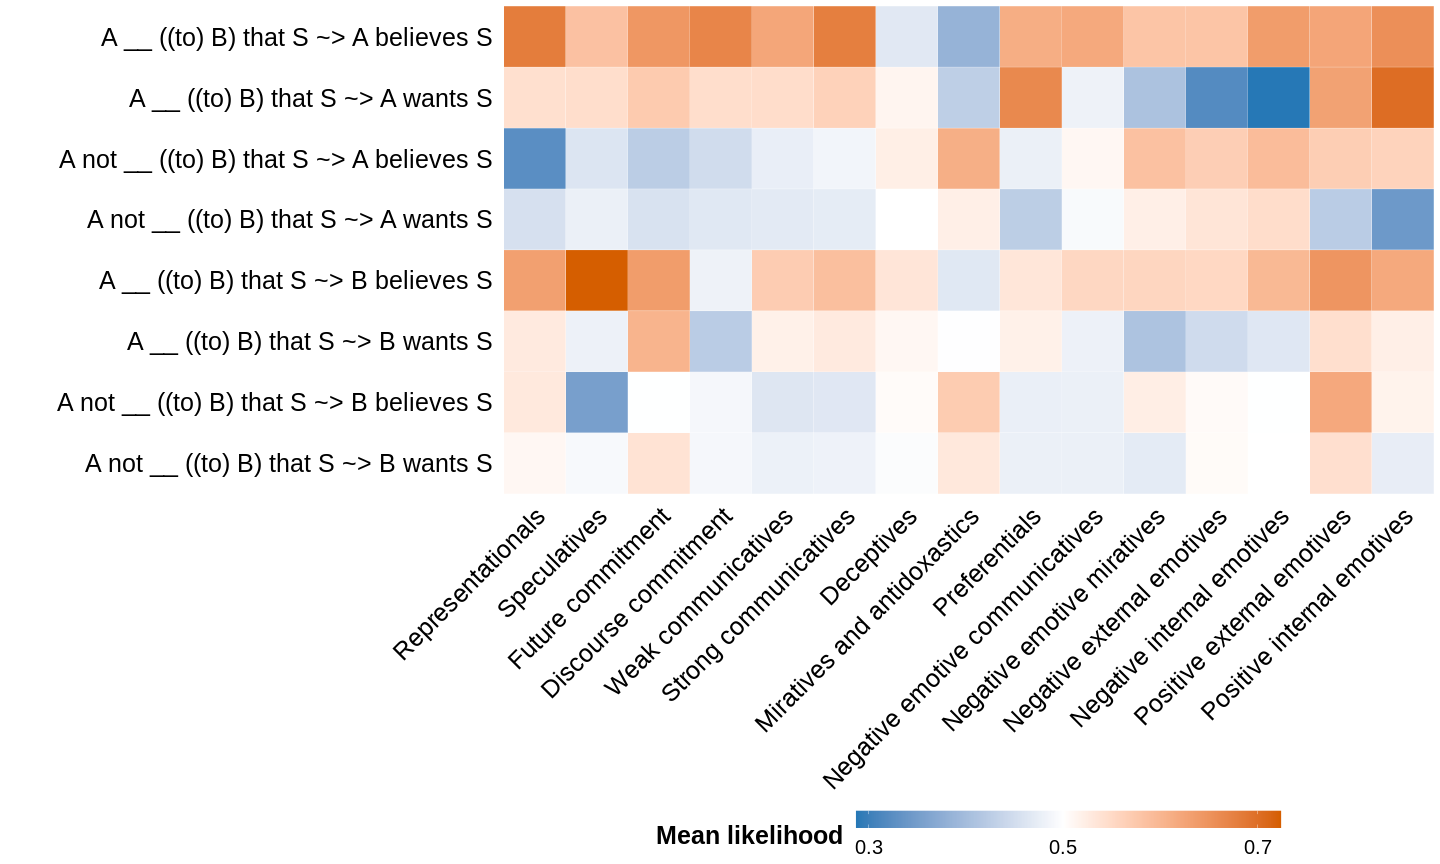

In [45]:
%%R -i best_belief_desire_locs_melt -w 20 -h 12 -u in

library(tidyverse)

theme_set(theme_bw())

belief_desire_template_order = rev(c('A __ ((to) B) that S ~> A believes S',
                                     'A __ ((to) B) that S ~> A wants S',
                                     'A not __ ((to) B) that S ~> A believes S',
                                     'A not __ ((to) B) that S ~> A wants S',
                                     'A __ ((to) B) that S ~> B believes S',
                                     'A __ ((to) B) that S ~> B wants S',
                                     'A not __ ((to) B) that S ~> B believes S',
                                     'A not __ ((to) B) that S ~> B wants S'))

best_belief_desire_locs_melt$template <- ordered(best_belief_desire_locs_melt$template,
                                                levels=belief_desire_template_order)

cluster_order = c('Representationals',
                  'Speculatives',
                  'Future commitment',
                  'Discourse commitment',
                  'Weak communicatives',
                  'Strong communicatives',
                  'Deceptives',
                  'Miratives and antidoxastics',
                  'Preferentials',
                  'Negative emotive communicatives',
                  'Negative emotive miratives',
                  'Negative external emotives',
                  'Negative internal emotives',
                  'Positive external emotives',
                  'Positive internal emotives')

best_belief_desire_locs_melt$label <- ordered(best_belief_desire_locs_melt$label,
                                                levels=cluster_order)


g = ggplot(best_belief_desire_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))



ggsave('plots/belief_desire-loadings-15.pdf', width=20, height=12)
ggsave('plots/belief_desire-loadings-15.png', width=20, height=12)

g

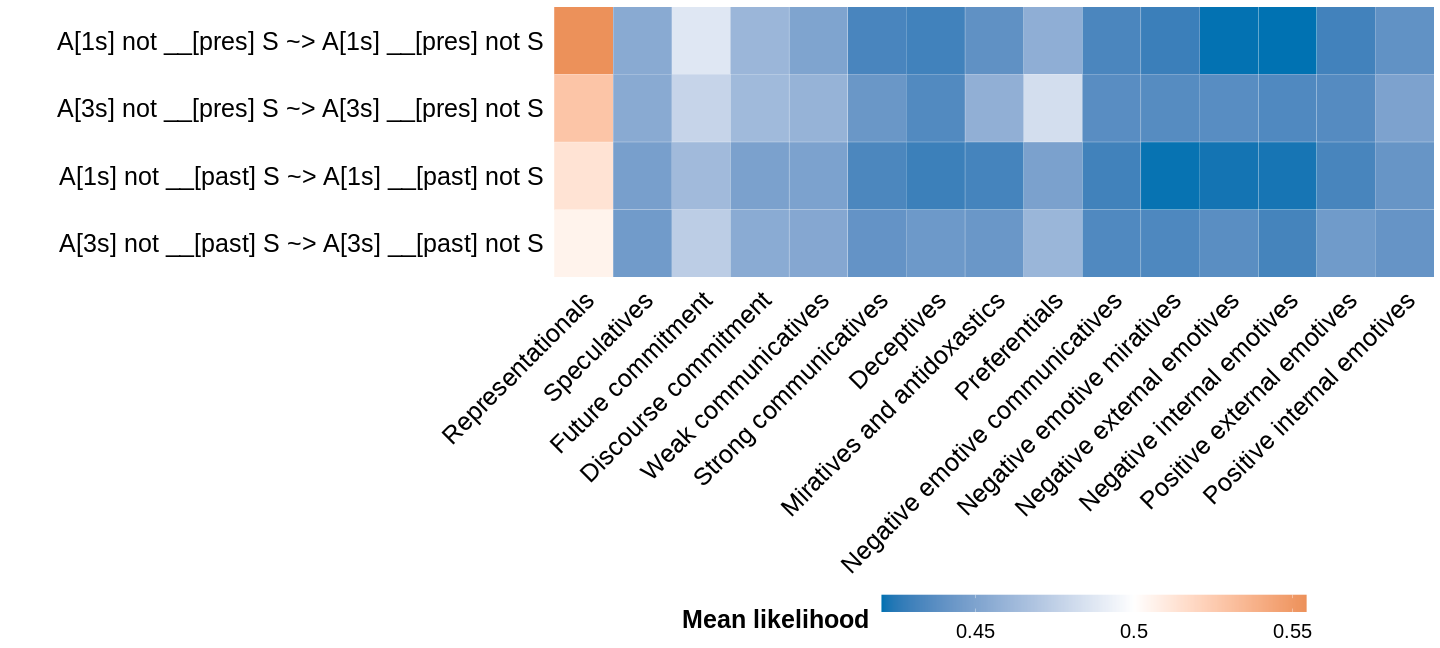

In [46]:
%%R -i best_negraising_locs_melt -w 20 -h 9 -u in

library(tidyverse)

theme_set(theme_bw())

negraising_template_order = rev(c('A[1s] not __[pres] S ~> A[1s] __[pres] not S',
                                  'A[3s] not __[pres] S ~> A[3s] __[pres] not S',
                                  'A[1s] not __[past] S ~> A[1s] __[past] not S',
                                  'A[3s] not __[past] S ~> A[3s] __[past] not S'))

best_negraising_locs_melt$template <- ordered(best_negraising_locs_melt$template,
                                              levels=negraising_template_order)

best_negraising_locs_melt$label <- ordered(best_negraising_locs_melt$label,
                                           levels=cluster_order)

g = ggplot(best_negraising_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.1, -0.05, 0, 0.05, 0.1),
                     labels=c(-0.1, -0.05, 0, 0.05, 0.1)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/negraising-loadings-15.pdf', width=20, height=9)
ggsave('plots/negraising-loadings-15.png', width=20, height=9)

g

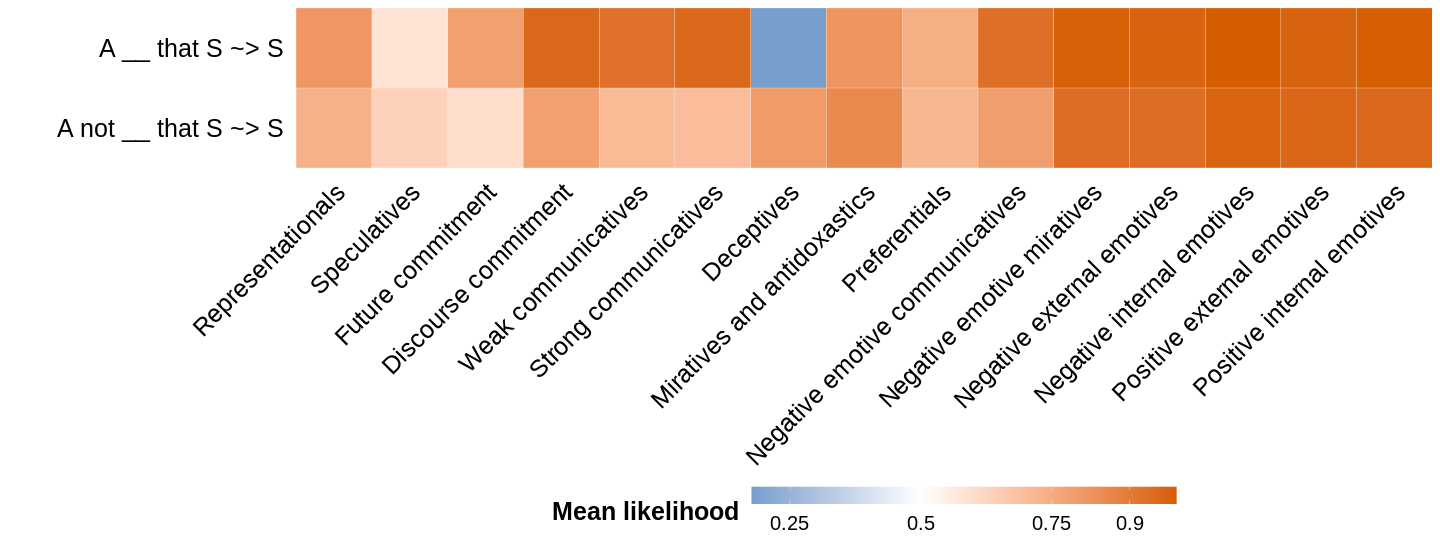

In [47]:
%%R -i best_veridicality_locs_melt -w 20 -h 7.5 -u in

library(tidyverse)

theme_set(theme_bw())

veridicality_template_order = rev(c('A __ that S ~> S', 'A not __ that S ~> S'))

best_veridicality_locs_melt$template <- ordered(best_veridicality_locs_melt$template, 
                                                 levels=veridicality_template_order)

best_veridicality_locs_melt$label <- ordered(best_veridicality_locs_melt$label,
                                             levels=cluster_order)

g = ggplot(best_veridicality_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/veridicality-loadings-15.png', width=20, height=7.5)
ggsave('plots/veridicality-loadings-15.pdf', width=20, height=7.5)

g

To determine a set of generalizations about these clusters, we apply principal component analysis (PCA) to the parameters of the property-specific probability distributions for each cluster.

In [48]:
all_locs_melt = pd.concat([best_veridicality_locs_melt,
                           best_negraising_locs_melt,
                           best_belief_desire_locs_melt])

all_locs = all_locs_melt.pivot_table(index='label', columns='template', values='value')

all_locs

template,A __ ((to) B) that S ~> A believes S,A __ ((to) B) that S ~> A wants S,A __ ((to) B) that S ~> B believes S,A __ ((to) B) that S ~> B wants S,A __ that S ~> S,A not __ ((to) B) that S ~> A believes S,A not __ ((to) B) that S ~> A wants S,A not __ ((to) B) that S ~> B believes S,A not __ ((to) B) that S ~> B wants S,A not __ that S ~> S,A[1s] not __[past] S ~> A[1s] __[past] not S,A[1s] not __[pres] S ~> A[1s] __[pres] not S,A[3s] not __[past] S ~> A[3s] __[past] not S,A[3s] not __[pres] S ~> A[3s] __[pres] not S
label,,,,,,,,,,,,,,
Deceptives,0.466159,0.513352,0.535140,0.510562,0.177602,0.522091,0.499734,0.505250,0.494998,0.803748,0.428920,0.430372,0.443830,0.435114
Discourse commitment,0.669368,0.545246,0.481017,0.423422,0.958340,0.447006,0.465275,0.488317,0.488478,0.787647,0.448700,0.460681,0.454069,0.462715
Future commitment,0.644471,0.571838,0.636418,0.603941,0.787380,0.424072,0.456845,0.499390,0.538588,0.599168,0.462898,0.487104,0.473325,0.477251
Miratives and antidoxastics,0.384249,0.427350,0.465883,0.498696,0.820778,0.611143,0.521164,0.570399,0.531307,0.859775,0.431375,0.439467,0.442871,0.456722
Negative emotive communicatives,0.619516,0.480528,0.554495,0.479661,0.937042,0.510993,0.492191,0.477842,0.477699,0.792817,0.430294,0.432993,0.434447,0.437048
Negative emotive miratives,0.580471,0.408033,0.556565,0.409337,0.980643,0.585688,0.521460,0.522711,0.470372,0.943504,0.421016,0.428766,0.433958,0.436366
Negative external emotives,0.580348,0.318860,0.553537,0.446454,0.970572,0.567089,0.535669,0.506572,0.506077,0.942840,0.422061,0.420748,0.437451,0.436860
Negative internal emotives,0.636484,0.287578,0.597090,0.463713,0.988244,0.592208,0.546231,0.499401,0.499455,0.967821,0.422309,0.420570,0.431290,0.434500
Positive external emotives,0.624344,0.629120,0.646625,0.544011,0.972823,0.567695,0.423637,0.619781,0.543123,0.961259,0.432060,0.430637,0.444897,0.436035


In [49]:
pca = PCA().fit(all_locs.apply(lambda x: (x-x.mean())/x.std(), axis=0))

pca_components = pd.DataFrame(pca.components_, columns=all_locs.columns)

pca_components_melt = pd.melt(pca_components.T.reset_index(), id_vars="template")

pca_components_melt

,template,variable,value
0,A __ ((to) B) that S ~> A believes S,0,0.186894
1,A __ ((to) B) that S ~> A wants S,0,0.239054
2,A __ ((to) B) that S ~> B believes S,0,0.165569
3,A __ ((to) B) that S ~> B wants S,0,0.244227
4,A __ that S ~> S,0,-0.065039
...,...,...,...
191,A not __ that S ~> S,13,0.417110
192,A[1s] not __[past] S ~> A[1s] __[past] not S,13,-0.283920
193,A[1s] not __[pres] S ~> A[1s] __[pres] not S,13,0.423116
194,A[3s] not __[past] S ~> A[3s] __[past] not S,13,0.214290


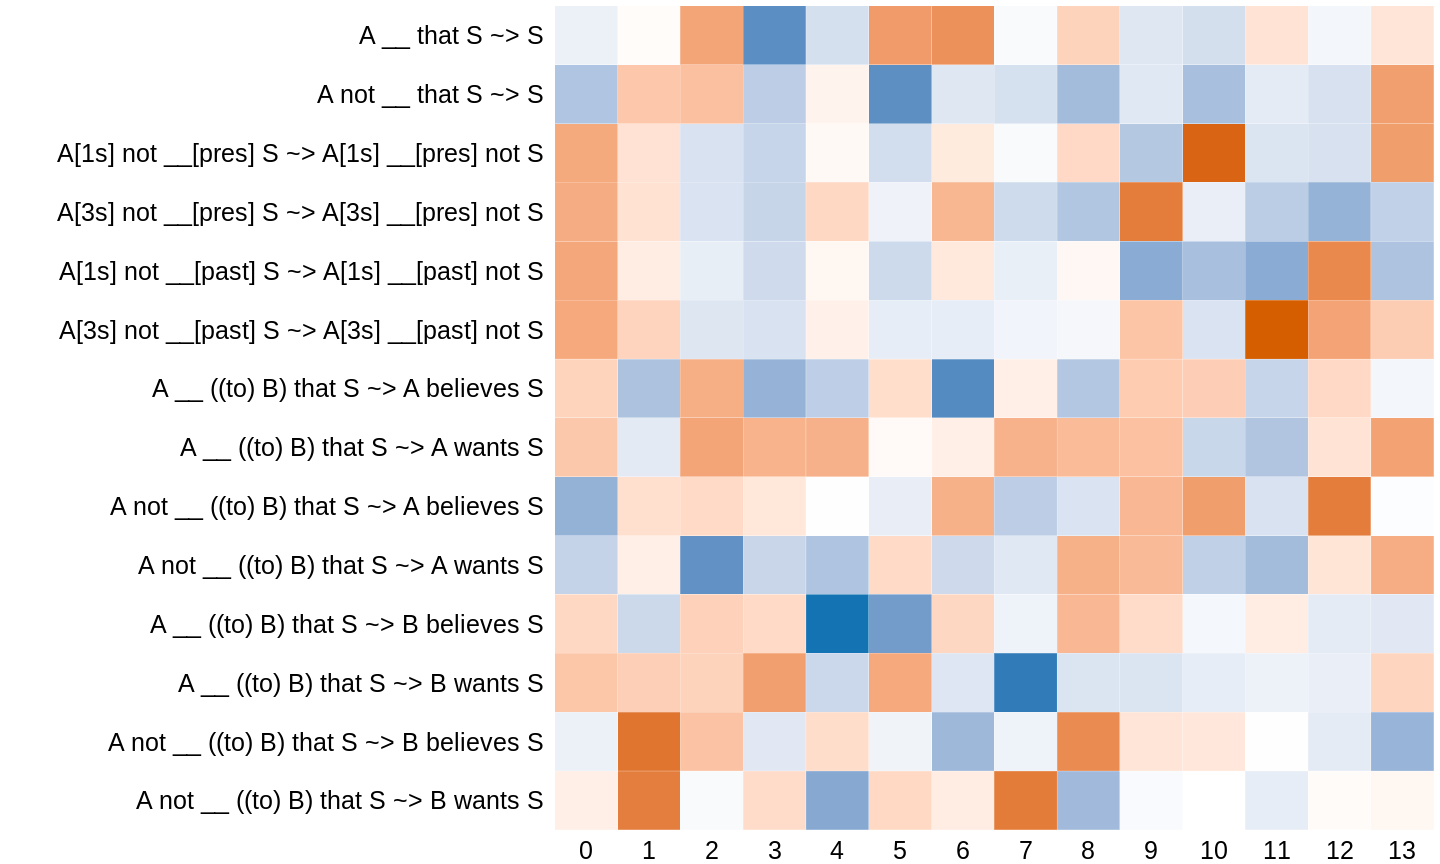

In [50]:
%%R -i pca_components_melt -w 20 -h 12 -u in

pca_components_melt$template = ordered(pca_components_melt$template,
                                      levels=c(belief_desire_template_order,
                                               negraising_template_order,
                                              veridicality_template_order))

g = ggplot(pca_components_melt, aes(y=template, x=as.factor(variable), fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
theme(axis.text=element_text(size=25, color="black"),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.position="none",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/pca-loadings-15.png', width=20, height=12)
ggsave('plots/pca-loadings-15.pdf', width=20, height=12)

g

Finally, to visualize the relationship between each cluster and the syntax, we plot the coefficients of the best regression mapping clusters to syntax.

In [51]:
ma_cast_cats = pd.merge(ma_cast, best_model['component_probs_any'], 
                        left_index=True, right_index=True)

component_cols = list(range(best_n_components))

X = ma_cast_cats[component_cols]
Y = ma_cast_cats.drop(columns=component_cols)

best_regression = RidgeCV(alphas=[0.001, 0.1, 0.2, 0.5, 1., 2., 5., 10.], cv=5).fit(X, Y)

In [52]:
best_regression_coefs = pd.DataFrame(best_regression.coef_, 
                                     index=ma_cast.columns, 
                                     columns=best_model['component_probs_any'].columns)

best_regression_coefs_melt = pd.melt(best_regression_coefs.reset_index(), id_vars='frame')

best_regression_coefs_melt['label'] = best_regression_coefs_melt.variable.map(cluster_labels)

best_regression_coefs_melt

,frame,variable,value,label
0,NP Ved,0,-0.325095,Negative internal emotives
1,NP Ved NP,0,-0.308804,Negative internal emotives
2,NP Ved NP VP,0,0.186790,Negative internal emotives
3,NP Ved NP VPing,0,0.066453,Negative internal emotives
4,NP Ved NP that S,0,0.451657,Negative internal emotives
...,...,...,...,...
745,NP was Ved whether S[+future],14,0.508913,Negative emotive miratives
746,NP was Ved whether to VP,14,0.364859,Negative emotive miratives
747,NP was Ved whichNP S,14,0.310214,Negative emotive miratives
748,NP was Ved whichNP to VP,14,0.402820,Negative emotive miratives


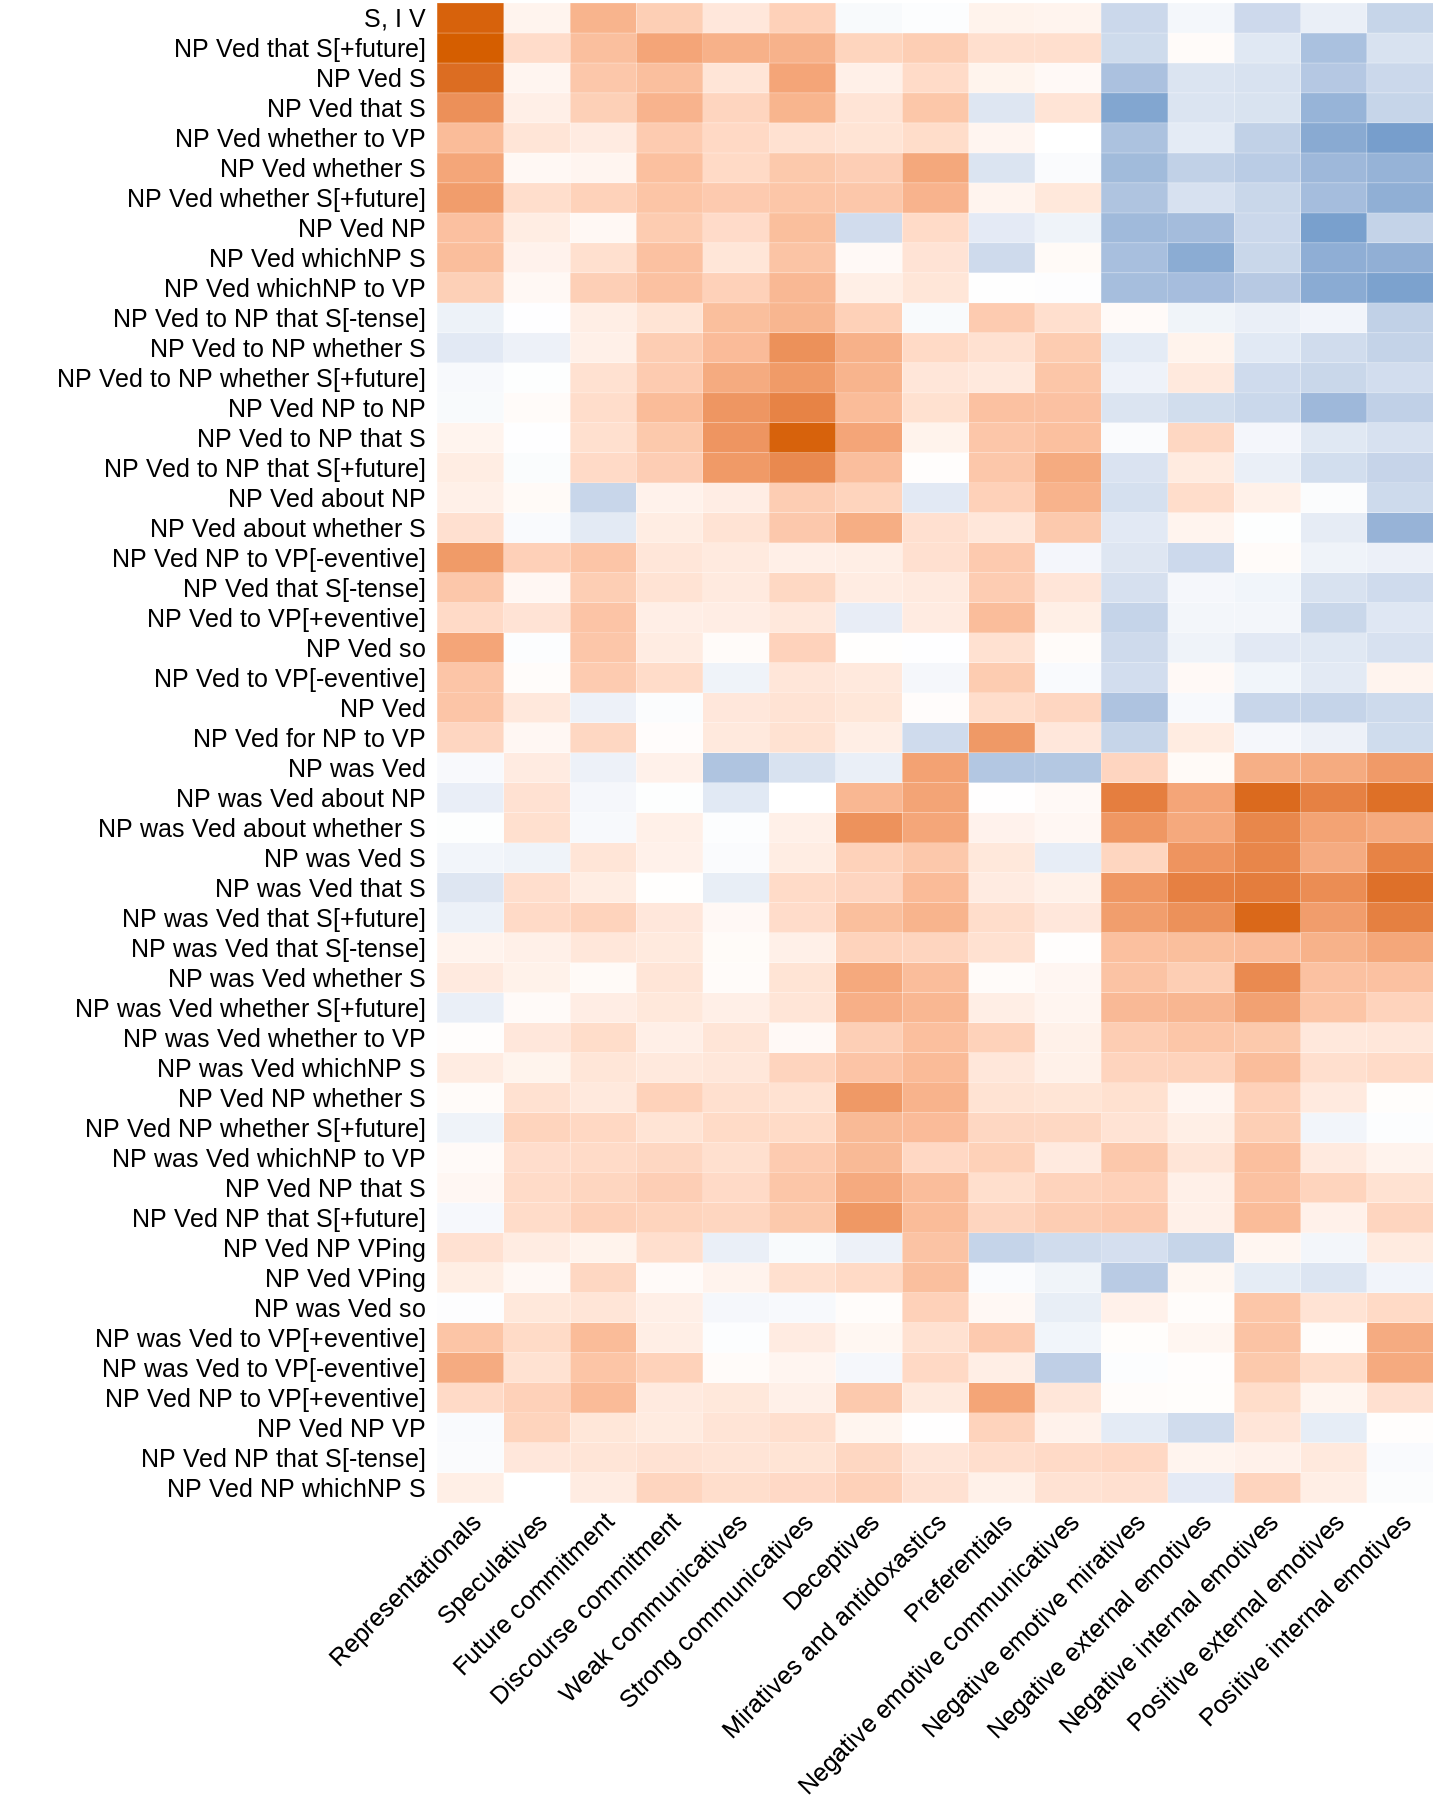

In [53]:
%%R -i best_regression_coefs -i best_regression_coefs_melt -w 20 -h 25 -u in

best_regression_coefs_melt$label = ordered(best_regression_coefs_melt$label,
                                      levels=cluster_order)

frame_order = row.names(best_regression_coefs)[rev(hclust(dist(best_regression_coefs))$order)]

best_regression_coefs_melt$frame = ordered(best_regression_coefs_melt$frame,
                                      levels=frame_order)

g = ggplot(best_regression_coefs_melt, aes(y=frame, x=label, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00") +
theme(axis.text=element_text(size=25, color="black"),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      axis.text.x=element_text(angle=45, hjust=1),
      legend.position="none",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/regression-coefs-15.png', width=20, height=25)
ggsave('plots/regression-coefs-15.pdf', width=20, height=25)

g